In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#from google.colab import files
#files.upload()

In [3]:
# Carga Fichero

import pandas as pd
path="/content/drive/MyDrive/Cajamar/"
datos = pd.read_csv(path+'Modelar_UH2022.txt',sep='|',parse_dates=['SAMPLETIME'],infer_datetime_format=True)

In [4]:
#Modelar_UH2022_10_Contadores.txt
datos[datos['ID']<11].to_csv('Modelar_UH2022_10_Contadores.txt',sep='|',index=False,float_format='%.0f')

In [5]:
datos[datos['ID']<3].to_csv('Modelar_UH2022_2_Contadores.txt',sep='|',index=False,float_format='%.0f')

In [6]:
datos[datos['ID']==2735].to_csv('Modelar_UH2022_Contador_2735.txt',sep='|',index=False,float_format='%.0f')

In [7]:
datos[datos['ID']==2561].to_csv('Modelar_UH2022_Contador_2561.txt',sep='|',index=False,float_format='%.0f')

In [8]:
datos[datos['ID']==2562].to_csv('Modelar_UH2022_Contador_2562.txt',sep='|',index=False,float_format='%.0f')

In [9]:
datos[datos['ID']==167].to_csv('Modelar_UH2022_Contador_167.txt',sep='|',index=False,float_format='%.0f')

In [10]:
datos[datos['ID']==2521].to_csv('Modelar_UH2022_Contador_2521.txt',sep='|',index=False,float_format='%.0f')

# CLASE PARA PROYECTO CAJAMAR

In [11]:
import pandas as pd
path="/content/drive/MyDrive/Cajamar/"
Normal_better=pd.read_csv(path+'Normal_better')
Lista_Normal_better = Normal_better['Salida'].tolist()
print(Lista_Normal_better)

[0, 1, 2, 3, 4, 0, 6, 7, 8, 0, 10, 11, 0, 0, 14, 0, 0, 0, 0, 19, 0, 0, 0, 23, 0, 25, 0, 0, 28, 29, 30, 31, 0, 33, 0, 0, 36, 0, 38, 39, 40, 41, 42, 0, 44, 0, 46, 0, 0, 0, 50, 51, 52, 53, 0, 55, 0, 57, 58, 59, 0, 61, 62, 63, 0, 65, 0, 67, 68, 69, 0, 71, 0, 0, 74, 0, 76, 77, 0, 0, 80, 0, 0, 0, 84, 0, 86, 0, 0, 89, 90, 0, 92, 93, 94, 95, 0, 97, 0, 0, 100, 101, 0, 103, 0, 105, 106, 107, 108, 109, 0, 111, 0, 0, 114, 0, 116, 117, 0, 119, 120, 121, 0, 0, 0, 0, 126, 0, 0, 129, 130, 131, 0, 133, 134, 0, 136, 0, 0, 0, 140, 141, 142, 143, 0, 145, 146, 0, 0, 149, 0, 0, 0, 153, 154, 0, 156, 157, 0, 0, 160, 161, 162, 0, 0, 0, 0, 167, 168, 169, 0, 171, 172, 173, 174, 175, 0, 0, 178, 0, 180, 0, 182, 0, 0, 185, 0, 187, 0, 189, 0, 0, 192, 193, 194, 195, 196, 197, 198, 0, 200, 201, 0, 0, 0, 205, 0, 207, 208, 209, 210, 211, 0, 0, 0, 215, 0, 0, 0, 0, 220, 221, 222, 0, 224, 0, 226, 227, 228, 0, 230, 231, 232, 233, 0, 0, 236, 237, 238, 0, 240, 241, 0, 243, 244, 0, 0, 0, 0, 249, 0, 251, 252, 253, 254, 0, 0, 0,

In [12]:
!pip install skforecast

In [13]:
# Librerias

import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import timedelta
from datetime import date
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster
import model_selection_no_print
#from typing import Union, Optional
from sklearn.preprocessing import StandardScaler
import math
from joblib import dump, load
import pickle


class Contador(object):
    def __init__(self, datos_contador, ID, umbral, Modelo_Semanal):
        self.datos_contador = datos_contador
        self.ID = ID
        self.lista_contadores_defectuosos = [111, 658, 2460, 2464, 2466, 2481, 2483, 2489]
        self.umbral = umbral
        self.Modelo_Semanal = Modelo_Semanal
        self.Preprocesado()
        self.SinDatos = False  # NO TIENE DATOS DATASET VACIO
        #self.outlier = False
        self.dias = 0
        self.RMSE_Train = 0
        self.RMSE_Test = 0
        self.datos_test = pd.DataFrame()
        self.datos_test_semanal = pd.DataFrame()
        self.Mejor_Parametro = {}
        self.Mejor_Lag = 14 
        self.DiffConsumo = 0
        
        # {'ID','Dia_1':0,'Dia_2':0,'Dia_3':0,'Dia_4':0,'Dia_5':0,'Dia_6':0','Dia_7':0,'Semana_1':0,'Semana_2':0}
        self.Predicciones = [self.ID,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        
        if not datos_contador.empty:
            # CALCULO LECTURA CONTADOR Y CONSUMO JUNTANDO DECIMALES
            #
            #CALCULO DE LA LECTURA Y CONSUMO AGRUPANDO PARTE ENTERA Y DECIMAL
            self.datos_contador['LECTURA'] = self.datos_contador['READINGINTEGER'] + (self.datos_contador['READINGTHOUSANDTH'] / 100)
            self.datos_contador['CONSUMO'] = self.datos_contador['DELTAINTEGER'] + (self.datos_contador['DELTATHOUSANDTH'] / 100)
            
            #NORMALIZACIÓN A DISTRIBUCIÓN NORMAL(0,1) DE LECTURA Y CONSUMO
            self.datos_contador['LECTURA_NORMA'] = (self.datos_contador['LECTURA']-self.datos_contador['LECTURA'].mean())/self.datos_contador['LECTURA'].std()
            self.datos_contador['CONSUMO_NORMA'] = (self.datos_contador['CONSUMO']-self.datos_contador['CONSUMO'].mean())/self.datos_contador['CONSUMO'].std()
            
            # ELIMINANDO LOS OUTLIERS "DESTACADOS" DE LOS CONTADORES MARCADOS (DEJO COMENTADA UNA OPCIÓN PARA HACERLO TAMBIÉN CON EL RESTO DE CONTADORES)
            if self.ID in self.lista_contadores_defectuosos:
              if self.ID in [111, 658, 2560]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>6)[0]], inplace=True)
              elif self.ID in [2466, 2483, 2489]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>5)[0]], inplace=True)
              elif self.ID in [2464, 2481]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>10)[0]], inplace=True)
#           else:
#             self.datos_contador['CONSUMO'].drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA']>8)[0]], inplace=True)
            
            #FIJACIÓN DEL ÍNDICE TEMPORAL DE LA SERIE
            self.datos_contador = self.datos_contador.set_index('SAMPLETIME')

            #NORMALIZACIÓN MIN MAX DE LECTURA Y CONSUMO
            self.datos_contador['LECTURA_MINMAX'] = (self.datos_contador['LECTURA']-self.datos_contador['LECTURA'].min())/(self.datos_contador['LECTURA'].max()-self.datos_contador['LECTURA'].min())
            self.datos_contador['CONSUMO_MINMAX'] = (self.datos_contador['CONSUMO']-self.datos_contador['CONSUMO'].min())/(self.datos_contador['CONSUMO'].max()-self.datos_contador['CONSUMO'].min())
            
            #CÁLCULO DE LA DIFERENCIA DE LECTURAS EN CADA PASO DE TIEMPO PARA OBTENER EL CONSUMO A PARTIR DE LA LECTURA
            self.datos_contador['CONSUMO_CAL'] = self.datos_contador['LECTURA'].diff(1).fillna(0)
            
            #APLICACIÓN DE LA FUNCIÓN PARA VERIFICAR SI EL CONSUMO ES CORRECTO
            self.__Comprobar_Consumo()

            # CÁLCULO DE LA SUMA DE LOS CONSUMOS Y LA DIFERENCIA DE VALOR MÁXIMO Y MÍNIMO DE LA LECTURA DEL CONTADOR
            self.suma_consumo = self.datos_contador['CONSUMO'].sum()
            self.diferencia_lectura = self.datos_contador['LECTURA'].max()-self.datos_contador['LECTURA'].min()

            #BOOLEANO QUE DETERMINA SI LA SUMA DE LOS CONSUMOS Y LA DIFERENCIA MIN MAX DEL CONTADOR SON IGUALES
            if self.suma_consumo == self.diferencia_lectura:
              self.buenas_lecturas = True
            else:
              self.buenas_lecturas = False

            # CONSUMO POR DIAS
            # RESAMPLE
            
            self.datos_consumo = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1D', closed='left', label ='left').sum())

            # NORMALIZACIÓN NORMAL STÁNDARD
            self.datos_consumo['CONSUMO_NORM'] = (self.datos_consumo['CONSUMO'] - self.datos_consumo['CONSUMO'].mean()) / self.datos_consumo['CONSUMO'].std()
            self.datos_consumo['CONSUMO_NORM'].fillna(0, inplace=True)
            # NORMALIZACIÓN MIN MAX
            self.datos_consumo['CONSUMO_MIN_MAX'] = (self.datos_consumo['CONSUMO']-self.datos_consumo['CONSUMO'].min())/(self.datos_consumo['CONSUMO'].max()-self.datos_consumo['CONSUMO'].min())
            self.datos_consumo['CONSUMO_MIN_MAX'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=3
            self.datos_consumo['CONSUMO_MEDMOV3'] = self.datos_consumo['CONSUMO'].rolling(3).mean()
            self.datos_consumo['CONSUMO_MEDMOV3'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=4
            self.datos_consumo['CONSUMO_MEDMOV4'] = self.datos_consumo['CONSUMO'].rolling(4).mean()
            self.datos_consumo['CONSUMO_MEDMOV4'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=5
            self.datos_consumo['CONSUMO_MEDMOV5'] = self.datos_consumo['CONSUMO'].rolling(5).mean()
            self.datos_consumo['CONSUMO_MEDMOV5'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=6
            self.datos_consumo['CONSUMO_MEDMOV6'] = self.datos_consumo['CONSUMO'].rolling(6).mean()
            self.datos_consumo['CONSUMO_MEDMOV6'].fillna(0,inplace=True)


            # MEDIAS MÓVILES N=7
            self.datos_consumo['CONSUMO_MEDMOV7'] = self.datos_consumo['CONSUMO'].rolling(7).mean()
            self.datos_consumo['CONSUMO_MEDMOV7'].fillna(0,inplace=True)   

            #COGER SÓLO SEMANAS COMPLETAS
            self.datos_consumo_semanal = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1W', closed='left', label ='left',offset='-36h').sum())
            
            # ESTADISTICAS
            self.dias = len(self.datos_consumo.index)
            self.semanas = len(self.datos_consumo_semanal.index)
            #self.datos_consumo['Cuenta'] = self.datos_contador.groupby([self.datos_contador.index.year,self.datos_contador.index.month, self.datos_contador.index.day]).agg({'CONSUMO':'count'}).values
            
            self.fecha_inicio_contador= self.datos_consumo.index[0]
            self.fecha_fin_contador= self.datos_consumo.index[-1]
            
        else:
            self.datos_consumo = pd.DataFrame()
            self.SinDatos = True
            self.fecha_fin_contador = None

        # GENERACION DEL MODELO
        self.modelo()
    
    def __Comprobar_Consumo(self):
        # COMPRUEBA SI HAY MAS DE 1 LITRO DE DIFERENCIA ENTRE EL CONSUMO EL CALCULO DEL CONSUMO CON LA LECTURA DEL CONTADOR
        # EL VALOR ACUMULADO SE GUARDA EN DiffConsumo
        if not(self.datos_contador['CONSUMO_CAL'].equals(self.datos_contador['CONSUMO'])):
            for index, row in self.datos_contador.iterrows():
                if row['CONSUMO_CAL'] != row['CONSUMO'] and (np.absolute(row['CONSUMO_CAL'] - row['CONSUMO']) > 1):
                    #print(row['CONSUMO_CAL'] - row['CONSUMO'])
                    #print(index,row)
                    self.DiffConsumo += np.absolute(row['CONSUMO_CAL'] - row['CONSUMO'])
        
    def __Convertir_fecha(self, serie):
        fechas = []
        for año, mes, dia in serie.index:
            fechas.append(date(año,mes,dia))
        return fechas
    
    def Preprocesado(self):
        # SAMPLETIME READINGINTEGER	READINGTHOUSANDTH	DELTAINTEGER	DELTATHOUSANDTH
        # VALORES  NULOS 
        # VALORES ENTEROS INTERPOLAMOS
        

        self.datos_contador['READINGINTEGER'].interpolate(inplace=True)
        self.datos_contador['DELTAINTEGER'].interpolate(inplace=True)
        
        # VALORES DECIMALES SUSTITUIMOS POR CERO
        self.datos_contador['READINGTHOUSANDTH'].fillna(0,inplace=True)
        self.datos_contador['DELTATHOUSANDTH'].fillna(0,inplace=True)
        
        # ELIMINAR VALORES NEGATIVOS
        indices = self.datos_contador[self.datos_contador['READINGINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)
        indices = self.datos_contador[self.datos_contador['DELTAINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)


    def modelo(self):
        # DECISION DEL MODELO A TOMAR EN FUNCION DE LA ESTADISTICAS
        # CARGA DEL MODELO
        # PACO
        self.model = None
        if self.dias > self.umbral: 
            if self.fecha_fin_contador == date(2020,1,31):
                # RandomForestRegressor Diario
                self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=14)
                # RandomForestRegressor Semanal Paco
                self.model_Semanal = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=4)
                
            else:
                self.model = self.datos_consumo['CONSUMO'].mean()
        else:
            if self.dias > 0: 
                #if (self.fecha_fin_contador > date(2020,1,17)).bool() :    # HACE MEDIA SI TENEMOS DATOS EN LOS ULTIMOS 14 DIAS
                self.model = self.datos_consumo['CONSUMO'].mean()
                #else:
                #self.model = 0
            else:
                self.model = 0

    def Juntar_Datos(self):
        # REHACE EL MODELO CON LOS MEJORES PARAMETROS
        # JUNTA TODO EN datos_consumo
        # {'max_depth': 3, 'n_estimators': 200}        
        #del self.model
        #if self.dias > umbral:
            #self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=max(self.Mejor_Lag), 
            #                                max_depth=self.Mejor_Parametro['max_depth'],n_estimators=self.Mejor_Parametro['n_estimators'])

        self.datos_consumo = pd.concat([self.datos_consumo,self.datos_test])
        self.datos_test =pd.DataFrame()
        
    

class CajaMar_Water(object):
    def __init__(self,Ruta_Datos,Fecha_Inicio=date(2019,2,1),Fecha_Fin=date(2020,1,31),umbral_modelo=100, Modelo_Semanal=False):
        self.Ruta_Datos = Ruta_Datos
        self.Fecha_Inicio = Fecha_Inicio
        self.Fecha_Fin = Fecha_Fin
        self.umbral_modelo = umbral_modelo
        self.Modelo_Semanal = Modelo_Semanal    # True usamos dos modelos uno para dias y otro para semanas
        self.datos = pd.DataFrame()
        self.contadores = []
        self.dias_test = 14     # DIAS QUE SE RESERVAN PARA TEST EMPEZANDO POR LA FECHA MAS RECIENTE
        self.semanas_test = 2   # SEMANAS QUE SE RESERVAN PARA TEST
        self.Cargar_Datos()
        self.RMSE_Test_Promedio=0
        self.RMSE_Test_Suma=0
        self.RMSE_Todos = []
        self.RMSE_Todos_IDs = []
        
    

    def Cargar_Datos(self):
        print('CARGANDO DATOS.....')
        self.datos = pd.read_csv(self.Ruta_Datos,sep='|',parse_dates=['SAMPLETIME'],infer_datetime_format=True,encoding='utf-8')
        self.datos.sort_values(by=['ID','SAMPLETIME'],inplace=True)
 
        # GENERANDO CONTADORES
        print('GENERANDO CONTADORES.....')
        for ID in tqdm(pd.unique(self.datos['ID'])):
            # ALMACENAMOS ID DE CONTADOR Y BORRAMOS LA COLUMNA
            self.contadores.append(Contador(self.datos[self.datos['ID']==ID].drop('ID',axis=1),ID,self.umbral_modelo,self.Modelo_Semanal))

        print('PROCESO DE CARGA FINALIZADO')
    
    def PartirDatos(self):
        # Separar datos de entrenamiento y test / validacion (dias=0 no hace validacion)
        if self.dias_test > 0:     
            for contador in tqdm(self.contadores):
                if contador.SinDatos == False:      # COMPROBAMOS QUE HAY ALGUN REGISTRO
                    #if (contador.fecha_fin_contador==self.Fecha_Fin):
                    if contador.dias > self.dias_test + 1:    # COMPROBAMOS QUE HAY SUFICIENTES DATOS PARA HACER PARTICION
                        contador.datos_test = contador.datos_consumo.tail(self.dias_test)
                        contador.datos_consumo = contador.datos_consumo[0:-self.dias_test]
                    if contador.semanas > self.semanas_test + 1:
                        contador.datos_test_semanal = contador.datos_consumo_semanal.tail(self.semanas_test)
                        contador.datos_consumo_semanal = contador.datos_consumo_semanal[0:-self.semanas_test]


    
    def Grid_Search(self,ID,steps):
        # Hiperparámetros del regresor
        param_grid = {'n_estimators': [100],
              'max_depth': [5]}

        # Lags utilizados como predictores
        lags_grid = [14]

        resultados_grid = model_selection_no_print.grid_search_forecaster(
                                forecaster         = self.contadores[ID].model,
                                y                  = self.contadores[ID].datos_consumo['CONSUMO'],
                                param_grid         = param_grid,
                                lags_grid          = lags_grid,
                                steps              = steps,
                                refit              = True,
                                metric             = 'mean_squared_error',
                                initial_train_size = len(self.contadores[ID].datos_consumo) - 14,
                                return_best        = True,
                                verbose            = False)
        self.contadores[ID].RMSE_Train = math.sqrt(resultados_grid['metric'].head(1))
        self.contadores[ID].Mejor_Parametro = list(resultados_grid['params'])[0]
        self.contadores[ID].Mejor_Lag = max(list(resultados_grid['lags'].head(1))[0])
        

    def Entrenamiento(self,Grid=False):
        # Entrenamiento de los modelos en self.contadores(lista) 
        # iterar lista y llamar a self.contadores[iter].modelo.train
        # Rellena la variable self.contadores.Predicciones
        indexC = 0
        for contador in tqdm(self.contadores):
            if isinstance(contador.model,ForecasterAutoreg):    # COMPROBAMOS QUE ES UN MODELO
                if Grid:
                    self.Grid_Search(indexC,self.dias_test)
                    #contador.Juntar_Datos() #  JUNTA LOS DATOS PARA LUEGO HACER PREDICT
                
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_NORM'])
                if contador.ID not in Lista_Normal_better:
                  print(contador.ID)
                  contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV6'])
                else:
                  contador.model.fit(y=contador.datos_consumo['CONSUMO'])
                predict = contador.model.predict(steps=self.dias_test)
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_NORM'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MIN_MAX'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV3'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV4'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV5'])

                if self.Modelo_Semanal:
                    contador.model_Semanal.fit(y=contador.datos_consumo_semanal['CONSUMO'])
                    predict_semanal = contador.model_Semanal.predict(steps=self.semanas_test)
                # HAY QUE TENER EN CUENTA CUANDO TERMINAN LOS DATOS
                #predict = contador.model.predict(steps=self.dias_test) * contador.datos_consumo['CONSUMO'].std() + contador.datos_consumo['CONSUMO'].mean()
                #predict = contador.model.predict(steps=self.dias_test) * contador.datos_consumo['CONSUMO'].std() + contador.datos_consumo['CONSUMO'].mean()
                #predict = contador.model.predict(steps=self.dias_test)*(contador.datos_consumo['CONSUMO'].max()-contador.datos_consumo['CONSUMO'].min())+contador.datos_consumo['CONSUMO'].min()
                #predict = contador.model.predict(steps=self.dias_test)
                index = 1
                for predict_dia in predict[0:14]:    # GUARDA 14 DIAS PREDICCION
                    contador.Predicciones[index] = predict_dia
                    index += 1
                if self.Modelo_Semanal:
                    contador.Predicciones[15]=predict_semanal[0]              # GUARDA SEMANA1 PREDICCION
                    contador.Predicciones[16]=predict_semanal[1]              # GUARDA SEMANA2 PREDICCION
                else:
                    contador.Predicciones[15]=predict[0:7].sum()     # GUARDA SEMANA1 PREDICCION
                    contador.Predicciones[16]=predict[7:14].sum()    # GUARDA SEMANA2 PREDICCION
            else:
              for index in range(1,15):
                    contador.Predicciones[index] = contador.model  # GUARDAMOS MEDIA EN LOS 7 DIAS
              contador.Predicciones[15]=contador.model*7     # GUARDAMOS MEDIA SEMANA1
              contador.Predicciones[16]=contador.model*7     # GUARDAMOS MEDIA SEMANA2
            
            indexC += 1
                  

    def Calculo_RMSE(self):
        # Calculo rmse utlizando datos de test
        for contador in tqdm(self.contadores):
            #if contador.dias > 180 and len(contador.datos_test) == self.dias_test:  # VER LIMITE NO DEPENDE DE LA CLASE CONTADOR
            if len(contador.datos_test) == self.dias_test and len(contador.datos_test_semanal) == self.semanas_test:
                if self.Modelo_Semanal:
                    media_RMSE_semanal=math.sqrt(mean_squared_error(contador.datos_test_semanal['CONSUMO'] , [contador.Predicciones[15], contador.Predicciones[16]]))
                else:
                    media_RMSE_semanal=math.sqrt(mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][7:14].sum()] , [contador.Predicciones[15], contador.Predicciones[16]]))
                
                contador.RMSE_Test = 0.5*math.sqrt(mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8]))+0.5*media_RMSE_semanal
                # Sin raiz
                #media_RMSE_semanal=mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][7:14].sum()] , [contador.Predicciones[8], contador.Predicciones[9]])
                #contador.RMSE_Test = 0.5+mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8])+0.5*media_RMSE_semanal
                self.RMSE_Todos.append(contador.RMSE_Test)
                self.RMSE_Todos_IDs.append(contador.ID)

        self.RMSE_Test_Suma = sum(self.RMSE_Todos)
        if self.RMSE_Test_Suma != 0:
            self.RMSE_Test_Promedio = self.RMSE_Test_Suma / len(self.RMSE_Todos)
        else:
            print('ERROR NO HAY CALCULO DE RMSE')
        
    
    def GenerarResultados(self,equipo='Team2021IA3',numeral=1):
        # Mediante los datos predicciones generamos txt con el formato del datathon
        # Separando campos con “|”, el valor de la predicción en litros, y los decimales con “.” 2 decimales
        # Fichero: "Cajamar_Universitat de València (UV)_Team2021IA3_numeral.txt"
        
        columnas = ['ID','Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6','Dia_7','Semana_1','Semana_2']
        datos = []

        for contador in tqdm(self.contadores):
            datos.append(contador.Predicciones)
        
        print('TAMAÑO DE LOS DATOS: ', len(datos), 'x' ,len(datos[0]))
        
        dataset = pd.DataFrame(datos,columns=columnas)
        dataset.to_csv('Cajamar_Universitat de València (UV)_' + equipo + '_' + str(numeral) + '.txt',header=False ,sep='|' ,index=False ,decimal='.' ,float_format='%.2f')
         
    def GraficasEstadisticas(self,contador=0,Test=True):
        # GRÁFICAS DE CONTADORES INDIVIDUALES CON TEST Y PREDICCIONES
        if Test:
            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_test['CONSUMO'].plot(ax=ax, label='Test', linewidth=1)
            pd.DataFrame(self.contadores[contador].Predicciones[1:15],index=self.contadores[contador].datos_test['CONSUMO'].index[0:14],columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Test) + ' Contador: ' + str(contador))
            ax.legend();
        else:
            base = date(2020,2,1)
            index = [base + timedelta(days=x) for x in range(7)]
            index = pd.DataFrame(index)
            index.insert(1, 'SAMPLETIME', [base + timedelta(days=x) for x in range(7)], True)
            index['SAMPLETIME']=pd.to_datetime(index['SAMPLETIME'], format='%Y-%m-%d')
            index=index.set_index('SAMPLETIME')
            index_puro=index.drop([0],axis=1)
            index_puro['Predicción']=Proyecto.contadores[contador].Predicciones[1:8]
            #df_final=pd.DataFrame(index_puro.insert(1, 'Predicción', pd.Series(self.contadores[contador].Predicciones[1:8]), True))

            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_consumo['CONSUMO'].plot(ax=ax, label='Consumo', linewidth=1)
            index_puro.plot(ax=ax, label='Predicción', linewidth=1)
            #pd.DataFrame(self.contadores[contador].Predicciones[1:8],index=index_puro,columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Train) + ' Contador: ' + str(contador))
            ax.legend();

    def Guardar_Modelos(self,Ruta='./modelos/Modelo_ID_'):

        print('GUARDANDO MODELOS.....')
        for contador in tqdm(self.contadores):
            dump(contador.model,Ruta + str(contador.ID))

        

In [14]:
#Proyecto = CajaMar_Water('Modelar_UH2022.txt')
path="/content/drive/MyDrive/Cajamar/"
#Proyecto = CajaMar_Water(path+'Modelar_UH2022_10_Contadores.txt')
Proyecto = CajaMar_Water(path+'Modelar_UH2022.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_10_Contadores.txt', Modelo_Semanal=False)
#Proyecto = CajaMar_Water('Modelar_UH2022_3_Contadores.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2735.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2561.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2562.txt')

CARGANDO DATOS.....
GENERANDO CONTADORES.....


 97%|█████████▋| 2674/2747 [23:04<00:12,  5.82it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:182: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:182: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2719/2747 [23:14<00:04,  6.79it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:182: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date

PROCESO DE CARGA FINALIZADO


#SIN OUTLIERS EN CONTADORES DEFECTUOSOS

  0%|          | 5/2747 [00:02<23:01,  1.99it/s]

5


  0%|          | 9/2747 [00:04<21:50,  2.09it/s]

9


  0%|          | 12/2747 [00:06<21:39,  2.10it/s]

12


  0%|          | 13/2747 [00:06<21:40,  2.10it/s]

13


  1%|          | 15/2747 [00:07<23:14,  1.96it/s]

15


  1%|          | 16/2747 [00:08<23:02,  1.97it/s]

16


  1%|          | 17/2747 [00:08<22:33,  2.02it/s]

17


  1%|          | 18/2747 [00:09<22:18,  2.04it/s]

18


  1%|          | 20/2747 [00:10<22:52,  1.99it/s]

20


  1%|          | 21/2747 [00:10<23:25,  1.94it/s]

21


  1%|          | 22/2747 [00:10<20:28,  2.22it/s]

22


  1%|          | 24/2747 [00:11<21:27,  2.11it/s]

24


  1%|          | 26/2747 [00:12<22:34,  2.01it/s]

26


  1%|          | 27/2747 [00:13<21:27,  2.11it/s]

27


  1%|          | 32/2747 [00:15<21:52,  2.07it/s]

32


  1%|          | 34/2747 [00:16<21:39,  2.09it/s]

34


  1%|▏         | 35/2747 [00:17<21:02,  2.15it/s]

35


  1%|▏         | 37/2747 [00:18<21:27,  2.10it/s]

37


  2%|▏         | 43/2747 [00:21<22:07,  2.04it/s]

43


  2%|▏         | 45/2747 [00:22<22:37,  1.99it/s]

45


  2%|▏         | 47/2747 [00:23<23:06,  1.95it/s]

47


  2%|▏         | 48/2747 [00:23<22:48,  1.97it/s]

48


  2%|▏         | 49/2747 [00:24<22:22,  2.01it/s]

49


  2%|▏         | 54/2747 [00:26<22:37,  1.98it/s]

54


  2%|▏         | 56/2747 [00:27<21:22,  2.10it/s]

56


  2%|▏         | 60/2747 [00:29<22:14,  2.01it/s]

60


  2%|▏         | 64/2747 [00:31<19:37,  2.28it/s]

64


  2%|▏         | 66/2747 [00:32<20:27,  2.18it/s]

66


  3%|▎         | 70/2747 [00:33<20:54,  2.13it/s]

70


  3%|▎         | 72/2747 [00:34<21:35,  2.07it/s]

72


  3%|▎         | 73/2747 [00:35<19:37,  2.27it/s]

73


  3%|▎         | 75/2747 [00:36<19:45,  2.25it/s]

75


  3%|▎         | 78/2747 [00:37<20:31,  2.17it/s]

78


  3%|▎         | 79/2747 [00:38<20:50,  2.13it/s]

79


  3%|▎         | 81/2747 [00:38<19:49,  2.24it/s]

81


  3%|▎         | 82/2747 [00:39<19:47,  2.24it/s]

82


  3%|▎         | 83/2747 [00:39<20:12,  2.20it/s]

83


  3%|▎         | 85/2747 [00:40<20:44,  2.14it/s]

85


  3%|▎         | 87/2747 [00:41<19:09,  2.31it/s]

87


  3%|▎         | 88/2747 [00:42<20:11,  2.20it/s]

88


  3%|▎         | 91/2747 [00:43<18:18,  2.42it/s]

91


  3%|▎         | 96/2747 [00:45<20:37,  2.14it/s]

96


  4%|▎         | 98/2747 [00:46<21:31,  2.05it/s]

98


  4%|▎         | 99/2747 [00:47<21:19,  2.07it/s]

99


  4%|▎         | 102/2747 [00:48<19:13,  2.29it/s]

102


  4%|▍         | 104/2747 [00:49<20:39,  2.13it/s]

104


  4%|▍         | 110/2747 [00:52<23:37,  1.86it/s]

110


  4%|▍         | 112/2747 [00:53<23:22,  1.88it/s]

112


  4%|▍         | 113/2747 [00:54<22:17,  1.97it/s]

113


  4%|▍         | 115/2747 [00:55<21:46,  2.01it/s]

115


  4%|▍         | 118/2747 [00:56<15:51,  2.76it/s]

118


  4%|▍         | 122/2747 [00:58<20:08,  2.17it/s]

122


  4%|▍         | 123/2747 [00:58<20:14,  2.16it/s]

123


  5%|▍         | 124/2747 [00:58<19:57,  2.19it/s]

124


  5%|▍         | 125/2747 [00:59<20:08,  2.17it/s]

125


  5%|▍         | 127/2747 [01:00<21:04,  2.07it/s]

127


  5%|▍         | 128/2747 [01:00<20:50,  2.09it/s]

128


  5%|▍         | 132/2747 [01:02<22:17,  1.96it/s]

132


  5%|▍         | 135/2747 [01:04<21:50,  1.99it/s]

135


  5%|▍         | 137/2747 [01:05<19:45,  2.20it/s]

137


  5%|▌         | 138/2747 [01:05<20:03,  2.17it/s]

138


  5%|▌         | 139/2747 [01:06<19:43,  2.20it/s]

139


  5%|▌         | 144/2747 [01:08<22:03,  1.97it/s]

144


  5%|▌         | 147/2747 [01:10<21:56,  1.98it/s]

147


  5%|▌         | 148/2747 [01:10<21:39,  2.00it/s]

148


  5%|▌         | 150/2747 [01:11<20:06,  2.15it/s]

150


  5%|▌         | 151/2747 [01:12<22:57,  1.89it/s]

151


  6%|▌         | 152/2747 [01:12<21:44,  1.99it/s]

152


  6%|▌         | 155/2747 [01:14<21:25,  2.02it/s]

155


  6%|▌         | 158/2747 [01:15<21:51,  1.97it/s]

158


  6%|▌         | 159/2747 [01:16<22:14,  1.94it/s]

159


  6%|▌         | 163/2747 [01:18<21:22,  2.01it/s]

163


  6%|▌         | 164/2747 [01:18<21:00,  2.05it/s]

164


  6%|▌         | 165/2747 [01:19<21:26,  2.01it/s]

165


  6%|▌         | 166/2747 [01:19<21:14,  2.03it/s]

166


  6%|▌         | 170/2747 [01:21<18:18,  2.35it/s]

170


  6%|▋         | 176/2747 [01:24<19:56,  2.15it/s]

176


  6%|▋         | 177/2747 [01:24<17:59,  2.38it/s]

177


  7%|▋         | 179/2747 [01:25<19:40,  2.17it/s]

179


  7%|▋         | 181/2747 [01:26<19:03,  2.24it/s]

181


  7%|▋         | 183/2747 [01:27<20:53,  2.05it/s]

183


  7%|▋         | 184/2747 [01:27<20:52,  2.05it/s]

184


  7%|▋         | 186/2747 [01:28<19:45,  2.16it/s]

186


  7%|▋         | 188/2747 [01:29<20:52,  2.04it/s]

188


  7%|▋         | 190/2747 [01:30<20:55,  2.04it/s]

190


  7%|▋         | 191/2747 [01:31<21:06,  2.02it/s]

191


  7%|▋         | 199/2747 [01:35<22:28,  1.89it/s]

199


  7%|▋         | 202/2747 [01:36<21:13,  2.00it/s]

202


  7%|▋         | 203/2747 [01:37<20:29,  2.07it/s]

203


  7%|▋         | 204/2747 [01:37<19:51,  2.13it/s]

204


  7%|▋         | 206/2747 [01:38<20:48,  2.03it/s]

206


  8%|▊         | 212/2747 [01:40<16:39,  2.54it/s]

212


  8%|▊         | 213/2747 [01:41<17:25,  2.42it/s]

213


  8%|▊         | 214/2747 [01:41<18:08,  2.33it/s]

214


  8%|▊         | 216/2747 [01:42<20:13,  2.09it/s]

216


  8%|▊         | 217/2747 [01:43<20:30,  2.06it/s]

217


  8%|▊         | 218/2747 [01:43<20:25,  2.06it/s]

218


  8%|▊         | 219/2747 [01:44<19:34,  2.15it/s]

219


  8%|▊         | 223/2747 [01:46<20:46,  2.03it/s]

223


  8%|▊         | 225/2747 [01:47<21:30,  1.95it/s]

225


  8%|▊         | 229/2747 [01:49<21:22,  1.96it/s]

229


  9%|▊         | 234/2747 [01:51<16:30,  2.54it/s]

234


  9%|▊         | 235/2747 [01:51<17:14,  2.43it/s]

235


  9%|▊         | 239/2747 [01:53<19:37,  2.13it/s]

239


  9%|▉         | 242/2747 [01:55<21:06,  1.98it/s]

242


  9%|▉         | 245/2747 [01:56<20:04,  2.08it/s]

245


  9%|▉         | 246/2747 [01:56<19:55,  2.09it/s]

246


  9%|▉         | 247/2747 [01:57<19:25,  2.14it/s]

247


  9%|▉         | 248/2747 [01:57<19:46,  2.11it/s]

248


  9%|▉         | 250/2747 [01:58<19:01,  2.19it/s]

250


  9%|▉         | 255/2747 [02:01<20:43,  2.00it/s]

255


  9%|▉         | 256/2747 [02:01<20:32,  2.02it/s]

256


  9%|▉         | 257/2747 [02:02<20:17,  2.05it/s]

257


  9%|▉         | 258/2747 [02:02<20:45,  2.00it/s]

258


  9%|▉         | 260/2747 [02:03<20:58,  1.98it/s]

261


 10%|▉         | 264/2747 [02:05<18:09,  2.28it/s]

264


 10%|▉         | 265/2747 [02:05<18:31,  2.23it/s]

265


 10%|▉         | 266/2747 [02:06<17:51,  2.32it/s]

266


 10%|▉         | 268/2747 [02:06<15:48,  2.61it/s]

268


 10%|▉         | 269/2747 [02:07<17:08,  2.41it/s]

269


 10%|▉         | 271/2747 [02:08<18:48,  2.19it/s]

271


 10%|▉         | 274/2747 [02:09<17:10,  2.40it/s]

274


 10%|█         | 277/2747 [02:11<20:04,  2.05it/s]

277


 10%|█         | 278/2747 [02:11<19:56,  2.06it/s]

278


 10%|█         | 279/2747 [02:12<20:13,  2.03it/s]

279


 10%|█         | 281/2747 [02:12<19:27,  2.11it/s]

281


 10%|█         | 282/2747 [02:13<19:31,  2.10it/s]

282


 10%|█         | 283/2747 [02:13<19:52,  2.07it/s]

283


 10%|█         | 284/2747 [02:14<18:23,  2.23it/s]

284


 10%|█         | 287/2747 [02:15<19:33,  2.10it/s]

287


 10%|█         | 288/2747 [02:16<19:32,  2.10it/s]

288


 11%|█         | 292/2747 [02:18<21:23,  1.91it/s]

292


 11%|█         | 293/2747 [02:18<21:02,  1.94it/s]

294


 11%|█         | 295/2747 [02:19<16:11,  2.52it/s]

295


 11%|█         | 297/2747 [02:20<17:24,  2.35it/s]

297


 11%|█         | 299/2747 [02:21<19:25,  2.10it/s]

299


 11%|█         | 301/2747 [02:22<19:40,  2.07it/s]

301


 11%|█         | 305/2747 [02:24<21:08,  1.93it/s]

305


 11%|█         | 306/2747 [02:24<21:11,  1.92it/s]

306


 11%|█         | 308/2747 [02:25<19:57,  2.04it/s]

308


 11%|█▏        | 315/2747 [02:29<19:58,  2.03it/s]

315


 12%|█▏        | 320/2747 [02:31<19:47,  2.04it/s]

320


 12%|█▏        | 322/2747 [02:32<19:58,  2.02it/s]

322


 12%|█▏        | 323/2747 [02:33<18:40,  2.16it/s]

323


 12%|█▏        | 324/2747 [02:33<16:57,  2.38it/s]

324


 12%|█▏        | 325/2747 [02:33<18:16,  2.21it/s]

325


 12%|█▏        | 331/2747 [02:36<18:03,  2.23it/s]

331


 12%|█▏        | 338/2747 [02:40<20:51,  1.92it/s]

338


 12%|█▏        | 339/2747 [02:40<20:40,  1.94it/s]

339


 12%|█▏        | 340/2747 [02:41<20:46,  1.93it/s]

340


 12%|█▏        | 341/2747 [02:41<20:54,  1.92it/s]

341


 12%|█▏        | 343/2747 [02:42<20:05,  1.99it/s]

343


 13%|█▎        | 344/2747 [02:43<19:36,  2.04it/s]

344


 13%|█▎        | 345/2747 [02:43<19:22,  2.07it/s]

345


 13%|█▎        | 348/2747 [02:45<18:52,  2.12it/s]

348


 13%|█▎        | 349/2747 [02:45<18:36,  2.15it/s]

349


 13%|█▎        | 354/2747 [02:47<19:50,  2.01it/s]

354


 13%|█▎        | 355/2747 [02:48<18:11,  2.19it/s]

355


 13%|█▎        | 356/2747 [02:48<18:34,  2.15it/s]

356


 13%|█▎        | 357/2747 [02:49<16:40,  2.39it/s]

357


 13%|█▎        | 359/2747 [02:50<17:04,  2.33it/s]

359


 13%|█▎        | 363/2747 [02:51<18:02,  2.20it/s]

363


 13%|█▎        | 364/2747 [02:52<18:45,  2.12it/s]

364


 13%|█▎        | 365/2747 [02:52<18:44,  2.12it/s]

365


 13%|█▎        | 366/2747 [02:53<18:54,  2.10it/s]

366


 13%|█▎        | 367/2747 [02:53<18:55,  2.10it/s]

367


 13%|█▎        | 369/2747 [02:54<19:31,  2.03it/s]

369


 13%|█▎        | 370/2747 [02:55<19:25,  2.04it/s]

370


 14%|█▎        | 371/2747 [02:55<18:45,  2.11it/s]

372


 14%|█▎        | 373/2747 [02:56<14:36,  2.71it/s]

373


 14%|█▎        | 374/2747 [02:56<15:00,  2.64it/s]

374


 14%|█▎        | 377/2747 [02:57<15:29,  2.55it/s]

377


 14%|█▍        | 378/2747 [02:58<16:53,  2.34it/s]

378


 14%|█▍        | 382/2747 [03:00<19:58,  1.97it/s]

382


 14%|█▍        | 383/2747 [03:01<19:27,  2.02it/s]

383


 14%|█▍        | 385/2747 [03:02<19:39,  2.00it/s]

385


 14%|█▍        | 386/2747 [03:02<19:36,  2.01it/s]

387


 14%|█▍        | 388/2747 [03:03<14:55,  2.63it/s]

388


 14%|█▍        | 389/2747 [03:03<15:25,  2.55it/s]

389


 14%|█▍        | 391/2747 [03:04<17:29,  2.25it/s]

391


 14%|█▍        | 392/2747 [03:04<17:47,  2.21it/s]

392


 14%|█▍        | 393/2747 [03:05<17:53,  2.19it/s]

393


 14%|█▍        | 394/2747 [03:05<18:10,  2.16it/s]

394


 14%|█▍        | 395/2747 [03:06<18:15,  2.15it/s]

395


 14%|█▍        | 396/2747 [03:06<18:30,  2.12it/s]

396


 14%|█▍        | 397/2747 [03:07<18:35,  2.11it/s]

397


 15%|█▍        | 400/2747 [03:08<18:40,  2.09it/s]

400


 15%|█▍        | 401/2747 [03:09<18:49,  2.08it/s]

401


 15%|█▍        | 403/2747 [03:10<19:23,  2.01it/s]

403


 15%|█▍        | 407/2747 [03:12<19:19,  2.02it/s]

407


 15%|█▍        | 409/2747 [03:13<19:53,  1.96it/s]

409


 15%|█▍        | 410/2747 [03:13<19:49,  1.97it/s]

410


 15%|█▌        | 414/2747 [03:15<18:57,  2.05it/s]

414


 15%|█▌        | 416/2747 [03:16<19:33,  1.99it/s]

416


 15%|█▌        | 417/2747 [03:17<18:55,  2.05it/s]

417


 15%|█▌        | 418/2747 [03:17<18:49,  2.06it/s]

418


 15%|█▌        | 419/2747 [03:17<18:05,  2.15it/s]

419


 15%|█▌        | 423/2747 [03:19<18:22,  2.11it/s]

423


 16%|█▌        | 431/2747 [03:23<16:16,  2.37it/s]

431


 16%|█▌        | 432/2747 [03:23<17:00,  2.27it/s]

432


 16%|█▌        | 435/2747 [03:25<17:56,  2.15it/s]

435


 16%|█▌        | 437/2747 [03:26<19:09,  2.01it/s]

437


 16%|█▌        | 441/2747 [03:27<15:52,  2.42it/s]

442


 16%|█▌        | 443/2747 [03:28<13:15,  2.90it/s]

443


 16%|█▌        | 445/2747 [03:29<16:05,  2.38it/s]

445


 16%|█▌        | 446/2747 [03:29<16:50,  2.28it/s]

446


 16%|█▋        | 447/2747 [03:30<17:33,  2.18it/s]

447


 16%|█▋        | 448/2747 [03:30<17:52,  2.14it/s]

448


 16%|█▋        | 450/2747 [03:31<17:45,  2.16it/s]

450


 16%|█▋        | 451/2747 [03:32<17:16,  2.21it/s]

451


 16%|█▋        | 453/2747 [03:33<18:34,  2.06it/s]

453


 17%|█▋        | 456/2747 [03:34<18:34,  2.06it/s]

456


 17%|█▋        | 458/2747 [03:35<19:03,  2.00it/s]

458


 17%|█▋        | 459/2747 [03:36<18:57,  2.01it/s]

459


 17%|█▋        | 465/2747 [03:38<17:11,  2.21it/s]

465


 17%|█▋        | 472/2747 [03:42<18:03,  2.10it/s]

472


 17%|█▋        | 476/2747 [03:44<17:46,  2.13it/s]

476


 17%|█▋        | 477/2747 [03:44<18:17,  2.07it/s]

477


 18%|█▊        | 481/2747 [03:46<18:33,  2.04it/s]

481


 18%|█▊        | 483/2747 [03:47<18:56,  1.99it/s]

483


 18%|█▊        | 485/2747 [03:48<18:40,  2.02it/s]

485


 18%|█▊        | 486/2747 [03:49<19:02,  1.98it/s]

486


 18%|█▊        | 489/2747 [03:50<19:19,  1.95it/s]

489


 18%|█▊        | 490/2747 [03:51<18:27,  2.04it/s]

490


 18%|█▊        | 491/2747 [03:51<18:13,  2.06it/s]

491


 18%|█▊        | 492/2747 [03:52<18:25,  2.04it/s]

492


 18%|█▊        | 493/2747 [03:52<18:29,  2.03it/s]

493


 18%|█▊        | 494/2747 [03:53<18:46,  2.00it/s]

494


 18%|█▊        | 500/2747 [03:56<19:17,  1.94it/s]

500


 18%|█▊        | 503/2747 [03:57<19:04,  1.96it/s]

503


 18%|█▊        | 505/2747 [03:58<19:20,  1.93it/s]

505


 19%|█▊        | 511/2747 [04:01<19:32,  1.91it/s]

511


 19%|█▊        | 512/2747 [04:02<18:56,  1.97it/s]

512


 19%|█▉        | 516/2747 [04:04<18:21,  2.02it/s]

516


 19%|█▉        | 521/2747 [04:06<16:43,  2.22it/s]

521


 19%|█▉        | 523/2747 [04:07<17:36,  2.11it/s]

523


 19%|█▉        | 525/2747 [04:08<18:11,  2.03it/s]

526


 19%|█▉        | 529/2747 [04:10<15:52,  2.33it/s]

529


 19%|█▉        | 530/2747 [04:10<16:36,  2.22it/s]

530


 19%|█▉        | 531/2747 [04:11<17:07,  2.16it/s]

531


 19%|█▉        | 533/2747 [04:12<18:08,  2.03it/s]

533


 19%|█▉        | 535/2747 [04:13<18:15,  2.02it/s]

535


 20%|█▉        | 538/2747 [04:14<16:43,  2.20it/s]

538


 20%|█▉        | 539/2747 [04:14<17:25,  2.11it/s]

539


 20%|█▉        | 540/2747 [04:15<17:35,  2.09it/s]

540


 20%|█▉        | 543/2747 [04:16<18:21,  2.00it/s]

543


 20%|█▉        | 545/2747 [04:17<18:40,  1.97it/s]

545


 20%|█▉        | 549/2747 [04:19<16:42,  2.19it/s]

549


 20%|██        | 554/2747 [04:21<15:34,  2.35it/s]

554


 20%|██        | 555/2747 [04:22<16:12,  2.25it/s]

555


 20%|██        | 557/2747 [04:23<17:20,  2.10it/s]

557


 20%|██        | 558/2747 [04:23<16:51,  2.16it/s]

558


 20%|██        | 560/2747 [04:24<17:31,  2.08it/s]

560


 20%|██        | 562/2747 [04:25<17:56,  2.03it/s]

562


 20%|██        | 563/2747 [04:26<17:44,  2.05it/s]

563


 21%|██        | 565/2747 [04:27<16:56,  2.15it/s]

565


 21%|██        | 567/2747 [04:28<17:15,  2.10it/s]

567


 21%|██        | 570/2747 [04:29<18:08,  2.00it/s]

570


 21%|██        | 574/2747 [04:31<17:41,  2.05it/s]

574


 21%|██        | 576/2747 [04:32<17:49,  2.03it/s]

576


 21%|██        | 578/2747 [04:33<17:06,  2.11it/s]

578


 21%|██        | 581/2747 [04:35<18:05,  2.00it/s]

581


 21%|██        | 582/2747 [04:35<17:00,  2.12it/s]

582


 21%|██        | 583/2747 [04:35<17:10,  2.10it/s]

583


 21%|██▏       | 584/2747 [04:36<17:33,  2.05it/s]

584


 21%|██▏       | 585/2747 [04:36<17:34,  2.05it/s]

585


 21%|██▏       | 586/2747 [04:37<17:13,  2.09it/s]

586


 21%|██▏       | 587/2747 [04:37<17:32,  2.05it/s]

587


 21%|██▏       | 589/2747 [04:38<18:13,  1.97it/s]

589


 22%|██▏       | 592/2747 [04:40<18:51,  1.91it/s]

592


 22%|██▏       | 593/2747 [04:41<18:29,  1.94it/s]

593


 22%|██▏       | 596/2747 [04:42<18:02,  1.99it/s]

596


 22%|██▏       | 597/2747 [04:43<18:09,  1.97it/s]

597


 22%|██▏       | 601/2747 [04:45<18:55,  1.89it/s]

601


 22%|██▏       | 609/2747 [04:49<18:18,  1.95it/s]

609


 22%|██▏       | 610/2747 [04:49<18:08,  1.96it/s]

610


 22%|██▏       | 611/2747 [04:50<17:42,  2.01it/s]

611


 22%|██▏       | 613/2747 [04:51<16:57,  2.10it/s]

613


 22%|██▏       | 616/2747 [04:52<17:20,  2.05it/s]

616


 22%|██▏       | 617/2747 [04:53<17:18,  2.05it/s]

617


 22%|██▏       | 618/2747 [04:53<17:29,  2.03it/s]

618


 23%|██▎       | 619/2747 [04:54<17:04,  2.08it/s]

619


 23%|██▎       | 620/2747 [04:54<17:23,  2.04it/s]

620


 23%|██▎       | 622/2747 [04:55<17:48,  1.99it/s]

622


 23%|██▎       | 624/2747 [04:56<16:52,  2.10it/s]

624


 23%|██▎       | 625/2747 [04:56<15:58,  2.21it/s]

625


 23%|██▎       | 629/2747 [04:58<13:44,  2.57it/s]

629


 23%|██▎       | 630/2747 [04:58<14:29,  2.44it/s]

630


 23%|██▎       | 631/2747 [04:59<14:27,  2.44it/s]

631


 23%|██▎       | 633/2747 [05:00<15:36,  2.26it/s]

633


 23%|██▎       | 635/2747 [05:01<16:55,  2.08it/s]

635


 23%|██▎       | 636/2747 [05:01<17:49,  1.97it/s]

636


 23%|██▎       | 638/2747 [05:02<17:51,  1.97it/s]

638


 23%|██▎       | 639/2747 [05:03<15:29,  2.27it/s]

639


 23%|██▎       | 640/2747 [05:03<15:45,  2.23it/s]

640


 23%|██▎       | 641/2747 [05:04<16:15,  2.16it/s]

641


 23%|██▎       | 642/2747 [05:04<16:43,  2.10it/s]

642


 23%|██▎       | 643/2747 [05:04<16:51,  2.08it/s]

643


 23%|██▎       | 644/2747 [05:05<16:51,  2.08it/s]

644


 23%|██▎       | 645/2747 [05:05<16:46,  2.09it/s]

645


 24%|██▍       | 653/2747 [05:09<18:03,  1.93it/s]

653


 24%|██▍       | 654/2747 [05:10<17:08,  2.04it/s]

655


 24%|██▍       | 656/2747 [05:10<12:28,  2.79it/s]

656


 24%|██▍       | 658/2747 [05:11<14:36,  2.38it/s]

658


 24%|██▍       | 661/2747 [05:13<17:48,  1.95it/s]

661


 24%|██▍       | 662/2747 [05:14<22:52,  1.52it/s]

662


 24%|██▍       | 664/2747 [05:15<21:51,  1.59it/s]

664


 24%|██▍       | 665/2747 [05:15<19:30,  1.78it/s]

665


 24%|██▍       | 667/2747 [05:16<18:20,  1.89it/s]

667


 24%|██▍       | 668/2747 [05:17<17:39,  1.96it/s]

668


 24%|██▍       | 671/2747 [05:18<16:15,  2.13it/s]

671


 24%|██▍       | 672/2747 [05:19<16:02,  2.16it/s]

672


 25%|██▍       | 674/2747 [05:19<14:51,  2.33it/s]

674


 25%|██▍       | 675/2747 [05:20<14:17,  2.42it/s]

675


 25%|██▍       | 676/2747 [05:20<15:27,  2.23it/s]

676


 25%|██▍       | 677/2747 [05:21<14:22,  2.40it/s]

677


 25%|██▍       | 680/2747 [05:22<14:49,  2.32it/s]

680


 25%|██▍       | 681/2747 [05:23<15:21,  2.24it/s]

681


 25%|██▍       | 682/2747 [05:23<15:40,  2.20it/s]

682


 25%|██▍       | 684/2747 [05:24<17:03,  2.02it/s]

684


 25%|██▍       | 685/2747 [05:24<15:39,  2.19it/s]

685


 25%|██▌       | 688/2747 [05:26<17:04,  2.01it/s]

688


 25%|██▌       | 689/2747 [05:27<17:43,  1.94it/s]

689


 25%|██▌       | 692/2747 [05:28<18:35,  1.84it/s]

692


 25%|██▌       | 696/2747 [05:30<18:34,  1.84it/s]

696


 25%|██▌       | 698/2747 [05:31<17:17,  1.98it/s]

698


 26%|██▌       | 702/2747 [05:33<18:08,  1.88it/s]

702


 26%|██▌       | 706/2747 [05:35<16:38,  2.04it/s]

706


 26%|██▌       | 707/2747 [05:36<16:39,  2.04it/s]

707


 26%|██▌       | 708/2747 [05:36<15:22,  2.21it/s]

708


 26%|██▌       | 709/2747 [05:37<15:41,  2.17it/s]

709


 26%|██▌       | 713/2747 [05:38<15:01,  2.26it/s]

713


 26%|██▌       | 714/2747 [05:39<15:49,  2.14it/s]

714


 26%|██▌       | 719/2747 [05:42<17:05,  1.98it/s]

719


 26%|██▌       | 721/2747 [05:43<17:47,  1.90it/s]

721


 26%|██▋       | 724/2747 [05:44<16:02,  2.10it/s]

724


 26%|██▋       | 725/2747 [05:44<16:16,  2.07it/s]

725


 26%|██▋       | 727/2747 [05:45<16:32,  2.03it/s]

727


 27%|██▋       | 729/2747 [05:46<15:47,  2.13it/s]

729


 27%|██▋       | 732/2747 [05:48<15:50,  2.12it/s]

732


 27%|██▋       | 734/2747 [05:49<16:34,  2.02it/s]

734


 27%|██▋       | 737/2747 [05:50<17:27,  1.92it/s]

737


 27%|██▋       | 740/2747 [05:52<16:38,  2.01it/s]

740


 27%|██▋       | 742/2747 [05:53<15:34,  2.14it/s]

742


 27%|██▋       | 743/2747 [05:53<15:33,  2.15it/s]

743


 27%|██▋       | 744/2747 [05:54<16:04,  2.08it/s]

744


 27%|██▋       | 750/2747 [05:56<15:56,  2.09it/s]

750


 27%|██▋       | 751/2747 [05:57<15:58,  2.08it/s]

751


 27%|██▋       | 752/2747 [05:57<16:14,  2.05it/s]

752


 27%|██▋       | 753/2747 [05:58<15:58,  2.08it/s]

753


 27%|██▋       | 754/2747 [05:58<15:58,  2.08it/s]

754


 28%|██▊       | 759/2747 [06:01<16:55,  1.96it/s]

759


 28%|██▊       | 761/2747 [06:02<16:46,  1.97it/s]

761


 28%|██▊       | 763/2747 [06:03<16:40,  1.98it/s]

763


 28%|██▊       | 766/2747 [06:04<14:32,  2.27it/s]

766


 28%|██▊       | 767/2747 [06:05<15:07,  2.18it/s]

767


 28%|██▊       | 768/2747 [06:05<15:36,  2.11it/s]

768


 28%|██▊       | 772/2747 [06:07<16:28,  2.00it/s]

772


 28%|██▊       | 775/2747 [06:09<16:37,  1.98it/s]

775


 28%|██▊       | 778/2747 [06:10<15:32,  2.11it/s]

778


 28%|██▊       | 779/2747 [06:11<15:40,  2.09it/s]

779


 29%|██▊       | 785/2747 [06:14<16:30,  1.98it/s]

785


 29%|██▊       | 787/2747 [06:15<17:10,  1.90it/s]

787


 29%|██▊       | 788/2747 [06:15<17:46,  1.84it/s]

788


 29%|██▊       | 789/2747 [06:16<17:44,  1.84it/s]

789


 29%|██▉       | 790/2747 [06:16<17:04,  1.91it/s]

790


 29%|██▉       | 797/2747 [06:19<12:36,  2.58it/s]

797


 29%|██▉       | 800/2747 [06:21<15:48,  2.05it/s]

800


 29%|██▉       | 803/2747 [06:22<16:09,  2.01it/s]

803


 29%|██▉       | 804/2747 [06:23<15:25,  2.10it/s]

804


 29%|██▉       | 806/2747 [06:24<15:52,  2.04it/s]

806


 29%|██▉       | 807/2747 [06:24<16:08,  2.00it/s]

807


 29%|██▉       | 808/2747 [06:25<15:54,  2.03it/s]

808


 29%|██▉       | 809/2747 [06:25<15:19,  2.11it/s]

809


 30%|██▉       | 812/2747 [06:27<16:21,  1.97it/s]

812


 30%|██▉       | 813/2747 [06:27<15:38,  2.06it/s]

814


 30%|██▉       | 815/2747 [06:28<12:03,  2.67it/s]

815


 30%|██▉       | 820/2747 [06:30<15:22,  2.09it/s]

820


 30%|██▉       | 821/2747 [06:31<15:32,  2.07it/s]

821


 30%|███       | 826/2747 [06:33<15:32,  2.06it/s]

826


 30%|███       | 827/2747 [06:34<15:39,  2.04it/s]

827


 30%|███       | 828/2747 [06:34<15:20,  2.08it/s]

828


 30%|███       | 830/2747 [06:35<15:45,  2.03it/s]

830


 30%|███       | 833/2747 [06:37<15:51,  2.01it/s]

833


 30%|███       | 834/2747 [06:37<15:07,  2.11it/s]

834


 30%|███       | 835/2747 [06:37<15:37,  2.04it/s]

835


 31%|███       | 838/2747 [06:39<15:44,  2.02it/s]

838


 31%|███       | 841/2747 [06:41<16:28,  1.93it/s]

841


 31%|███       | 844/2747 [06:42<15:40,  2.02it/s]

844


 31%|███       | 845/2747 [06:42<15:32,  2.04it/s]

845


 31%|███       | 846/2747 [06:43<15:31,  2.04it/s]

846


 31%|███       | 848/2747 [06:44<14:13,  2.23it/s]

848


 31%|███       | 849/2747 [06:44<14:44,  2.15it/s]

849


 31%|███       | 853/2747 [06:46<15:46,  2.00it/s]

853


 31%|███       | 856/2747 [06:48<15:33,  2.03it/s]

856


 31%|███▏      | 859/2747 [06:49<16:05,  1.95it/s]

859


 31%|███▏      | 860/2747 [06:50<15:55,  1.98it/s]

861


 31%|███▏      | 862/2747 [06:50<12:31,  2.51it/s]

862


 31%|███▏      | 863/2747 [06:51<13:29,  2.33it/s]

863


 32%|███▏      | 866/2747 [06:52<14:46,  2.12it/s]

866


 32%|███▏      | 867/2747 [06:53<14:48,  2.12it/s]

867


 32%|███▏      | 869/2747 [06:54<13:25,  2.33it/s]

869


 32%|███▏      | 870/2747 [06:54<13:54,  2.25it/s]

870


 32%|███▏      | 871/2747 [06:55<14:26,  2.16it/s]

871


 32%|███▏      | 874/2747 [06:56<15:04,  2.07it/s]

874


 32%|███▏      | 877/2747 [06:58<15:42,  1.98it/s]

877


 32%|███▏      | 882/2747 [07:00<15:21,  2.02it/s]

882


 32%|███▏      | 885/2747 [07:01<13:47,  2.25it/s]

885


 32%|███▏      | 886/2747 [07:02<14:15,  2.18it/s]

886


 32%|███▏      | 888/2747 [07:03<14:55,  2.08it/s]

888


 33%|███▎      | 893/2747 [07:05<13:39,  2.26it/s]

893


 33%|███▎      | 894/2747 [07:05<13:12,  2.34it/s]

894


 33%|███▎      | 895/2747 [07:06<13:37,  2.26it/s]

895


 33%|███▎      | 896/2747 [07:06<13:54,  2.22it/s]

896


 33%|███▎      | 900/2747 [07:08<14:38,  2.10it/s]

900


 33%|███▎      | 901/2747 [07:09<14:41,  2.09it/s]

901


 33%|███▎      | 902/2747 [07:10<19:00,  1.62it/s]

902


 33%|███▎      | 903/2747 [07:10<17:52,  1.72it/s]

903


 33%|███▎      | 904/2747 [07:11<16:49,  1.83it/s]

904


 33%|███▎      | 905/2747 [07:11<16:15,  1.89it/s]

905


 33%|███▎      | 906/2747 [07:12<16:03,  1.91it/s]

906


 33%|███▎      | 908/2747 [07:13<15:16,  2.01it/s]

908


 33%|███▎      | 910/2747 [07:13<13:59,  2.19it/s]

910


 33%|███▎      | 911/2747 [07:14<14:04,  2.17it/s]

911


 33%|███▎      | 912/2747 [07:14<14:34,  2.10it/s]

912


 33%|███▎      | 913/2747 [07:15<15:05,  2.02it/s]

913


 33%|███▎      | 914/2747 [07:15<15:04,  2.03it/s]

914


 33%|███▎      | 918/2747 [07:17<12:31,  2.44it/s]

918


 34%|███▎      | 921/2747 [07:19<14:55,  2.04it/s]

921


 34%|███▎      | 922/2747 [07:19<14:54,  2.04it/s]

922


 34%|███▎      | 924/2747 [07:20<15:06,  2.01it/s]

924


 34%|███▎      | 925/2747 [07:21<15:19,  1.98it/s]

925


 34%|███▎      | 926/2747 [07:21<15:38,  1.94it/s]

926


 34%|███▎      | 927/2747 [07:22<15:40,  1.94it/s]

927


 34%|███▍      | 930/2747 [07:23<13:16,  2.28it/s]

930


 34%|███▍      | 931/2747 [07:24<13:54,  2.18it/s]

931


 34%|███▍      | 933/2747 [07:24<14:07,  2.14it/s]

933


 34%|███▍      | 937/2747 [07:26<14:42,  2.05it/s]

937


 34%|███▍      | 938/2747 [07:27<14:01,  2.15it/s]

938


 34%|███▍      | 940/2747 [07:28<14:08,  2.13it/s]

940


 34%|███▍      | 941/2747 [07:28<14:17,  2.11it/s]

941


 34%|███▍      | 942/2747 [07:29<14:25,  2.09it/s]

942


 34%|███▍      | 943/2747 [07:29<14:28,  2.08it/s]

943


 34%|███▍      | 945/2747 [07:30<14:20,  2.09it/s]

945


 34%|███▍      | 947/2747 [07:31<14:45,  2.03it/s]

947


 35%|███▍      | 950/2747 [07:33<15:02,  1.99it/s]

950


 35%|███▍      | 957/2747 [07:36<15:33,  1.92it/s]

957


 35%|███▍      | 959/2747 [07:37<13:16,  2.24it/s]

959


 35%|███▍      | 961/2747 [07:38<14:11,  2.10it/s]

961


 35%|███▌      | 962/2747 [07:39<14:24,  2.06it/s]

962


 35%|███▌      | 964/2747 [07:40<15:01,  1.98it/s]

964


 35%|███▌      | 967/2747 [07:41<12:45,  2.32it/s]

967


 35%|███▌      | 969/2747 [07:42<13:26,  2.20it/s]

970


 35%|███▌      | 972/2747 [07:43<11:32,  2.56it/s]

972


 35%|███▌      | 975/2747 [07:44<12:59,  2.27it/s]

975


 36%|███▌      | 977/2747 [07:45<14:39,  2.01it/s]

977


 36%|███▌      | 978/2747 [07:46<13:20,  2.21it/s]

978


 36%|███▌      | 979/2747 [07:46<13:43,  2.15it/s]

979


 36%|███▌      | 981/2747 [07:47<12:43,  2.31it/s]

981


 36%|███▌      | 982/2747 [07:47<11:58,  2.46it/s]

982


 36%|███▌      | 986/2747 [07:49<14:01,  2.09it/s]

986


 36%|███▌      | 987/2747 [07:50<14:22,  2.04it/s]

987


 36%|███▌      | 993/2747 [07:53<14:01,  2.08it/s]

993


 36%|███▌      | 995/2747 [07:54<14:06,  2.07it/s]

995


 36%|███▋      | 997/2747 [07:55<13:41,  2.13it/s]

997


 36%|███▋      | 998/2747 [07:55<12:26,  2.34it/s]

998


 36%|███▋      | 999/2747 [07:55<12:48,  2.27it/s]

999


 36%|███▋      | 1000/2747 [07:56<13:27,  2.16it/s]

1000


 36%|███▋      | 1001/2747 [07:56<13:51,  2.10it/s]

1001


 37%|███▋      | 1004/2747 [07:58<14:22,  2.02it/s]

1004


 37%|███▋      | 1005/2747 [07:58<14:10,  2.05it/s]

1005


 37%|███▋      | 1007/2747 [07:59<12:22,  2.34it/s]

1007


 37%|███▋      | 1008/2747 [08:00<12:58,  2.23it/s]

1008


 37%|███▋      | 1010/2747 [08:01<13:48,  2.10it/s]

1010


 37%|███▋      | 1013/2747 [08:02<14:19,  2.02it/s]

1013


 37%|███▋      | 1015/2747 [08:03<11:21,  2.54it/s]

1015


 37%|███▋      | 1021/2747 [08:05<12:14,  2.35it/s]

1021


 37%|███▋      | 1024/2747 [08:06<10:17,  2.79it/s]

1024


 37%|███▋      | 1025/2747 [08:07<11:10,  2.57it/s]

1025


 37%|███▋      | 1026/2747 [08:07<11:43,  2.45it/s]

1026


 37%|███▋      | 1027/2747 [08:08<12:04,  2.37it/s]

1027


 38%|███▊      | 1032/2747 [08:11<14:37,  1.95it/s]

1032


 38%|███▊      | 1033/2747 [08:11<14:17,  2.00it/s]

1033


 38%|███▊      | 1034/2747 [08:11<13:50,  2.06it/s]

1034


 38%|███▊      | 1035/2747 [08:12<12:56,  2.20it/s]

1035


 38%|███▊      | 1037/2747 [08:13<12:47,  2.23it/s]

1037


 38%|███▊      | 1039/2747 [08:14<13:38,  2.09it/s]

1039


 38%|███▊      | 1041/2747 [08:15<13:44,  2.07it/s]

1042


 38%|███▊      | 1046/2747 [08:17<12:56,  2.19it/s]

1046


 38%|███▊      | 1048/2747 [08:18<12:00,  2.36it/s]

1048


 38%|███▊      | 1050/2747 [08:18<12:25,  2.28it/s]

1050


 38%|███▊      | 1051/2747 [08:19<12:58,  2.18it/s]

1051


 38%|███▊      | 1052/2747 [08:19<13:15,  2.13it/s]

1052


 38%|███▊      | 1055/2747 [08:21<14:16,  1.98it/s]

1055


 38%|███▊      | 1056/2747 [08:21<14:01,  2.01it/s]

1056


 39%|███▊      | 1059/2747 [08:23<14:42,  1.91it/s]

1059


 39%|███▊      | 1061/2747 [08:24<14:31,  1.93it/s]

1061


 39%|███▊      | 1063/2747 [08:25<14:37,  1.92it/s]

1063


 39%|███▊      | 1064/2747 [08:26<13:50,  2.03it/s]

1064


 39%|███▉      | 1065/2747 [08:26<13:08,  2.13it/s]

1065


 39%|███▉      | 1066/2747 [08:26<13:26,  2.08it/s]

1066


 39%|███▉      | 1069/2747 [08:28<13:35,  2.06it/s]

1069


 39%|███▉      | 1071/2747 [08:29<13:24,  2.08it/s]

1071


 39%|███▉      | 1072/2747 [08:29<13:30,  2.07it/s]

1072


 39%|███▉      | 1073/2747 [08:30<12:51,  2.17it/s]

1073


 39%|███▉      | 1075/2747 [08:31<13:59,  1.99it/s]

1075


 39%|███▉      | 1078/2747 [08:32<13:44,  2.02it/s]

1078


 39%|███▉      | 1080/2747 [08:33<13:57,  1.99it/s]

1080


 39%|███▉      | 1081/2747 [08:34<13:45,  2.02it/s]

1081


 39%|███▉      | 1082/2747 [08:34<13:52,  2.00it/s]

1082


 40%|███▉      | 1086/2747 [08:36<13:43,  2.02it/s]

1086


 40%|███▉      | 1087/2747 [08:37<13:36,  2.03it/s]

1087


 40%|███▉      | 1088/2747 [08:37<13:32,  2.04it/s]

1088


 40%|███▉      | 1089/2747 [08:38<13:33,  2.04it/s]

1089


 40%|███▉      | 1092/2747 [08:39<13:52,  1.99it/s]

1092


 40%|███▉      | 1094/2747 [08:40<13:51,  1.99it/s]

1094


 40%|███▉      | 1095/2747 [08:41<13:31,  2.04it/s]

1095


 40%|███▉      | 1096/2747 [08:41<13:27,  2.04it/s]

1096


 40%|███▉      | 1098/2747 [08:42<11:57,  2.30it/s]

1098


 40%|████      | 1104/2747 [08:45<13:58,  1.96it/s]

1104


 40%|████      | 1106/2747 [08:46<14:35,  1.88it/s]

1106


 40%|████      | 1108/2747 [08:47<14:29,  1.89it/s]

1108


 40%|████      | 1109/2747 [08:47<12:55,  2.11it/s]

1109


 40%|████      | 1110/2747 [08:48<12:56,  2.11it/s]

1110


 40%|████      | 1112/2747 [08:49<13:01,  2.09it/s]

1112


 41%|████      | 1115/2747 [08:50<12:53,  2.11it/s]

1115


 41%|████      | 1117/2747 [08:51<13:14,  2.05it/s]

1117


 41%|████      | 1119/2747 [08:52<13:03,  2.08it/s]

1119


 41%|████      | 1120/2747 [08:53<12:31,  2.16it/s]

1120


 41%|████      | 1121/2747 [08:53<11:20,  2.39it/s]

1121


 41%|████      | 1126/2747 [08:56<13:25,  2.01it/s]

1126


 41%|████      | 1127/2747 [08:56<13:45,  1.96it/s]

1127


 41%|████      | 1128/2747 [08:57<13:47,  1.96it/s]

1128


 41%|████      | 1129/2747 [08:57<13:39,  1.98it/s]

1129


 41%|████▏     | 1135/2747 [09:00<10:13,  2.63it/s]

1135


 41%|████▏     | 1137/2747 [09:00<09:48,  2.74it/s]

1137


 41%|████▏     | 1138/2747 [09:01<10:36,  2.53it/s]

1138


 41%|████▏     | 1140/2747 [09:02<11:49,  2.26it/s]

1140


 42%|████▏     | 1144/2747 [09:04<13:21,  2.00it/s]

1144


 42%|████▏     | 1146/2747 [09:05<12:45,  2.09it/s]

1146


 42%|████▏     | 1148/2747 [09:05<11:17,  2.36it/s]

1148


 42%|████▏     | 1149/2747 [09:06<11:57,  2.23it/s]

1149


 42%|████▏     | 1150/2747 [09:06<12:42,  2.09it/s]

1150


 42%|████▏     | 1151/2747 [09:07<12:45,  2.08it/s]

1151


 42%|████▏     | 1155/2747 [09:09<12:36,  2.10it/s]

1155


 42%|████▏     | 1157/2747 [09:10<12:46,  2.07it/s]

1157


 42%|████▏     | 1158/2747 [09:10<12:53,  2.06it/s]

1158


 42%|████▏     | 1160/2747 [09:11<12:57,  2.04it/s]

1160


 42%|████▏     | 1161/2747 [09:12<12:56,  2.04it/s]

1161


 42%|████▏     | 1163/2747 [09:13<12:44,  2.07it/s]

1163


 43%|████▎     | 1169/2747 [09:17<17:13,  1.53it/s]

1169


 43%|████▎     | 1173/2747 [09:18<11:56,  2.20it/s]

1173


 43%|████▎     | 1176/2747 [09:19<09:37,  2.72it/s]

1176


 43%|████▎     | 1177/2747 [09:20<10:25,  2.51it/s]

1177


 43%|████▎     | 1178/2747 [09:20<10:49,  2.42it/s]

1178


 43%|████▎     | 1182/2747 [09:22<11:21,  2.30it/s]

1182


 43%|████▎     | 1183/2747 [09:22<11:09,  2.34it/s]

1183


 43%|████▎     | 1185/2747 [09:23<11:58,  2.17it/s]

1185


 43%|████▎     | 1186/2747 [09:24<12:11,  2.13it/s]

1186


 43%|████▎     | 1187/2747 [09:24<12:25,  2.09it/s]

1187


 43%|████▎     | 1189/2747 [09:25<12:51,  2.02it/s]

1189


 43%|████▎     | 1190/2747 [09:26<12:59,  2.00it/s]

1190


 43%|████▎     | 1191/2747 [09:26<12:39,  2.05it/s]

1191


 43%|████▎     | 1192/2747 [09:27<12:38,  2.05it/s]

1192


 43%|████▎     | 1193/2747 [09:27<13:05,  1.98it/s]

1193


 43%|████▎     | 1194/2747 [09:28<12:22,  2.09it/s]

1194


 44%|████▎     | 1195/2747 [09:28<12:46,  2.02it/s]

1195


 44%|████▎     | 1197/2747 [09:29<12:26,  2.08it/s]

1197


 44%|████▎     | 1199/2747 [09:30<12:25,  2.08it/s]

1199


 44%|████▍     | 1202/2747 [09:31<12:31,  2.06it/s]

1202


 44%|████▍     | 1203/2747 [09:32<12:19,  2.09it/s]

1203


 44%|████▍     | 1210/2747 [09:36<13:16,  1.93it/s]

1210


 44%|████▍     | 1213/2747 [09:37<13:23,  1.91it/s]

1213


 44%|████▍     | 1215/2747 [09:38<11:26,  2.23it/s]

1215


 44%|████▍     | 1217/2747 [09:39<12:00,  2.12it/s]

1217


 44%|████▍     | 1218/2747 [09:39<12:07,  2.10it/s]

1218


 44%|████▍     | 1219/2747 [09:40<12:11,  2.09it/s]

1219


 44%|████▍     | 1220/2747 [09:40<12:16,  2.07it/s]

1220


 44%|████▍     | 1221/2747 [09:41<12:13,  2.08it/s]

1221


 45%|████▍     | 1225/2747 [09:43<12:43,  1.99it/s]

1225


 45%|████▍     | 1227/2747 [09:44<12:01,  2.11it/s]

1227


 45%|████▍     | 1228/2747 [09:44<12:28,  2.03it/s]

1228


 45%|████▍     | 1230/2747 [09:45<13:05,  1.93it/s]

1230


 45%|████▍     | 1231/2747 [09:46<12:27,  2.03it/s]

1231


 45%|████▍     | 1232/2747 [09:46<12:21,  2.04it/s]

1232


 45%|████▍     | 1233/2747 [09:47<12:09,  2.08it/s]

1233


 45%|████▍     | 1234/2747 [09:47<11:54,  2.12it/s]

1234


 45%|████▍     | 1235/2747 [09:48<12:08,  2.07it/s]

1235


 45%|████▌     | 1237/2747 [09:49<11:56,  2.11it/s]

1237


 45%|████▌     | 1238/2747 [09:49<11:56,  2.11it/s]

1238


 45%|████▌     | 1239/2747 [09:50<12:16,  2.05it/s]

1239


 45%|████▌     | 1240/2747 [09:50<12:27,  2.02it/s]

1240


 45%|████▌     | 1241/2747 [09:51<12:15,  2.05it/s]

1241


 45%|████▌     | 1243/2747 [09:52<12:54,  1.94it/s]

1243


 45%|████▌     | 1244/2747 [09:52<12:37,  1.98it/s]

1244


 45%|████▌     | 1245/2747 [09:52<11:48,  2.12it/s]

1245


 45%|████▌     | 1249/2747 [09:54<09:51,  2.53it/s]

1249


 46%|████▌     | 1250/2747 [09:55<10:30,  2.37it/s]

1250


 46%|████▌     | 1251/2747 [09:55<11:11,  2.23it/s]

1251


 46%|████▌     | 1252/2747 [09:56<11:29,  2.17it/s]

1252


 46%|████▌     | 1254/2747 [09:57<11:49,  2.11it/s]

1254


 46%|████▌     | 1255/2747 [09:57<11:56,  2.08it/s]

1255


 46%|████▌     | 1257/2747 [09:58<12:16,  2.02it/s]

1257


 46%|████▌     | 1260/2747 [10:00<12:30,  1.98it/s]

1260


 46%|████▌     | 1262/2747 [10:00<11:16,  2.19it/s]

1262


 46%|████▌     | 1263/2747 [10:01<11:36,  2.13it/s]

1263


 46%|████▌     | 1264/2747 [10:01<11:44,  2.10it/s]

1264


 46%|████▌     | 1266/2747 [10:02<12:17,  2.01it/s]

1266


 46%|████▌     | 1267/2747 [10:03<11:33,  2.14it/s]

1267


 46%|████▌     | 1268/2747 [10:03<11:38,  2.12it/s]

1268


 46%|████▌     | 1270/2747 [10:04<11:59,  2.05it/s]

1270


 46%|████▋     | 1271/2747 [10:05<12:16,  2.01it/s]

1271


 46%|████▋     | 1273/2747 [10:06<12:02,  2.04it/s]

1273


 46%|████▋     | 1274/2747 [10:06<11:58,  2.05it/s]

1274


 46%|████▋     | 1275/2747 [10:07<11:58,  2.05it/s]

1275


 46%|████▋     | 1276/2747 [10:07<12:00,  2.04it/s]

1276


 46%|████▋     | 1277/2747 [10:08<12:05,  2.03it/s]

1277


 47%|████▋     | 1278/2747 [10:08<11:52,  2.06it/s]

1278


 47%|████▋     | 1279/2747 [10:09<11:19,  2.16it/s]

1279


 47%|████▋     | 1281/2747 [10:10<11:41,  2.09it/s]

1281


 47%|████▋     | 1283/2747 [10:11<12:34,  1.94it/s]

1283


 47%|████▋     | 1284/2747 [10:11<12:26,  1.96it/s]

1284


 47%|████▋     | 1285/2747 [10:12<12:10,  2.00it/s]

1285


 47%|████▋     | 1287/2747 [10:13<11:08,  2.18it/s]

1287


 47%|████▋     | 1291/2747 [10:14<11:18,  2.15it/s]

1291


 47%|████▋     | 1292/2747 [10:15<11:31,  2.10it/s]

1292


 47%|████▋     | 1294/2747 [10:16<12:30,  1.94it/s]

1294


 47%|████▋     | 1295/2747 [10:17<12:13,  1.98it/s]

1295


 47%|████▋     | 1296/2747 [10:17<12:10,  1.99it/s]

1296


 47%|████▋     | 1297/2747 [10:17<10:57,  2.20it/s]

1297


 47%|████▋     | 1298/2747 [10:18<11:13,  2.15it/s]

1298


 47%|████▋     | 1299/2747 [10:18<11:45,  2.05it/s]

1299


 47%|████▋     | 1300/2747 [10:19<11:47,  2.05it/s]

1300


 47%|████▋     | 1301/2747 [10:19<12:07,  1.99it/s]

1301


 47%|████▋     | 1302/2747 [10:20<11:50,  2.03it/s]

1302


 48%|████▊     | 1306/2747 [10:22<11:55,  2.01it/s]

1306


 48%|████▊     | 1310/2747 [10:24<10:41,  2.24it/s]

1310


 48%|████▊     | 1311/2747 [10:24<10:59,  2.18it/s]

1311


 48%|████▊     | 1315/2747 [10:26<10:41,  2.23it/s]

1315


 48%|████▊     | 1320/2747 [10:29<11:56,  1.99it/s]

1320


 48%|████▊     | 1321/2747 [10:29<12:05,  1.96it/s]

1321


 48%|████▊     | 1322/2747 [10:30<11:56,  1.99it/s]

1322


 48%|████▊     | 1325/2747 [10:31<12:04,  1.96it/s]

1325


 48%|████▊     | 1326/2747 [10:32<11:59,  1.97it/s]

1326


 48%|████▊     | 1327/2747 [10:32<10:49,  2.19it/s]

1327


 48%|████▊     | 1330/2747 [10:34<11:17,  2.09it/s]

1330


 48%|████▊     | 1332/2747 [10:35<11:39,  2.02it/s]

1332


 49%|████▊     | 1335/2747 [10:36<10:33,  2.23it/s]

1335


 49%|████▊     | 1336/2747 [10:36<11:08,  2.11it/s]

1336


 49%|████▊     | 1338/2747 [10:37<11:17,  2.08it/s]

1339


 49%|████▉     | 1341/2747 [10:38<08:47,  2.66it/s]

1341


 49%|████▉     | 1342/2747 [10:39<09:39,  2.42it/s]

1342


 49%|████▉     | 1343/2747 [10:39<09:42,  2.41it/s]

1343


 49%|████▉     | 1344/2747 [10:40<10:23,  2.25it/s]

1344


 49%|████▉     | 1345/2747 [10:40<10:54,  2.14it/s]

1345


 49%|████▉     | 1346/2747 [10:41<11:21,  2.06it/s]

1346


 49%|████▉     | 1347/2747 [10:41<11:43,  1.99it/s]

1347


 49%|████▉     | 1348/2747 [10:42<11:52,  1.96it/s]

1348


 49%|████▉     | 1351/2747 [10:43<12:03,  1.93it/s]

1351


 49%|████▉     | 1352/2747 [10:44<12:07,  1.92it/s]

1352


 49%|████▉     | 1354/2747 [10:45<11:59,  1.94it/s]

1354


 49%|████▉     | 1355/2747 [10:45<11:59,  1.94it/s]

1355


 49%|████▉     | 1356/2747 [10:46<11:48,  1.96it/s]

1356


 49%|████▉     | 1359/2747 [10:47<12:26,  1.86it/s]

1359


 50%|████▉     | 1361/2747 [10:48<10:36,  2.18it/s]

1361


 50%|████▉     | 1362/2747 [10:49<09:44,  2.37it/s]

1362


 50%|████▉     | 1363/2747 [10:49<10:11,  2.26it/s]

1363


 50%|████▉     | 1364/2747 [10:50<10:23,  2.22it/s]

1364


 50%|████▉     | 1365/2747 [10:50<10:39,  2.16it/s]

1365


 50%|████▉     | 1366/2747 [10:50<10:41,  2.15it/s]

1366


 50%|█████     | 1375/2747 [10:54<10:20,  2.21it/s]

1375


 50%|█████     | 1376/2747 [10:55<10:30,  2.17it/s]

1376


 50%|█████     | 1380/2747 [10:57<11:24,  2.00it/s]

1380


 50%|█████     | 1381/2747 [10:57<11:15,  2.02it/s]

1381


 50%|█████     | 1382/2747 [10:58<11:24,  2.00it/s]

1382


 50%|█████     | 1383/2747 [10:58<11:32,  1.97it/s]

1383


 50%|█████     | 1385/2747 [10:59<11:27,  1.98it/s]

1385


 50%|█████     | 1386/2747 [11:00<11:20,  2.00it/s]

1386


 51%|█████     | 1388/2747 [11:01<11:28,  1.98it/s]

1388


 51%|█████     | 1389/2747 [11:01<11:10,  2.03it/s]

1389


 51%|█████     | 1391/2747 [11:02<11:08,  2.03it/s]

1391


 51%|█████     | 1392/2747 [11:03<11:16,  2.00it/s]

1392


 51%|█████     | 1394/2747 [11:04<11:38,  1.94it/s]

1394


 51%|█████     | 1395/2747 [11:04<11:45,  1.92it/s]

1395


 51%|█████     | 1400/2747 [11:07<11:24,  1.97it/s]

1400


 51%|█████     | 1401/2747 [11:07<11:19,  1.98it/s]

1401


 51%|█████     | 1402/2747 [11:08<10:42,  2.09it/s]

1402


 51%|█████     | 1405/2747 [11:09<11:10,  2.00it/s]

1405


 51%|█████     | 1406/2747 [11:10<11:09,  2.00it/s]

1406


 51%|█████▏    | 1410/2747 [11:12<10:29,  2.13it/s]

1410


 52%|█████▏    | 1415/2747 [11:14<11:23,  1.95it/s]

1415


 52%|█████▏    | 1417/2747 [11:15<11:29,  1.93it/s]

1417


 52%|█████▏    | 1420/2747 [11:17<10:55,  2.02it/s]

1420


 52%|█████▏    | 1422/2747 [11:18<10:56,  2.02it/s]

1422


 52%|█████▏    | 1424/2747 [11:19<10:32,  2.09it/s]

1424


 52%|█████▏    | 1427/2747 [11:20<10:09,  2.17it/s]

1427


 52%|█████▏    | 1431/2747 [11:22<09:31,  2.30it/s]

1431


 52%|█████▏    | 1432/2747 [11:22<09:38,  2.27it/s]

1432


 52%|█████▏    | 1433/2747 [11:23<09:48,  2.23it/s]

1433


 52%|█████▏    | 1434/2747 [11:23<09:36,  2.28it/s]

1434


 52%|█████▏    | 1435/2747 [11:24<10:01,  2.18it/s]

1435


 52%|█████▏    | 1436/2747 [11:24<10:03,  2.17it/s]

1436


 52%|█████▏    | 1437/2747 [11:25<10:26,  2.09it/s]

1437


 52%|█████▏    | 1438/2747 [11:25<10:34,  2.06it/s]

1438


 52%|█████▏    | 1439/2747 [11:26<10:33,  2.06it/s]

1439


 52%|█████▏    | 1442/2747 [11:27<09:38,  2.25it/s]

1442


 53%|█████▎    | 1444/2747 [11:28<09:20,  2.33it/s]

1444


 53%|█████▎    | 1446/2747 [11:29<09:05,  2.39it/s]

1446


 53%|█████▎    | 1447/2747 [11:29<09:25,  2.30it/s]

1447


 53%|█████▎    | 1451/2747 [11:31<10:14,  2.11it/s]

1451


 53%|█████▎    | 1453/2747 [11:32<10:35,  2.04it/s]

1453


 53%|█████▎    | 1454/2747 [11:32<10:09,  2.12it/s]

1454


 53%|█████▎    | 1455/2747 [11:33<10:08,  2.12it/s]

1455


 53%|█████▎    | 1457/2747 [11:34<10:36,  2.03it/s]

1457


 53%|█████▎    | 1458/2747 [11:34<10:42,  2.01it/s]

1458


 53%|█████▎    | 1459/2747 [11:35<10:34,  2.03it/s]

1459


 53%|█████▎    | 1460/2747 [11:35<10:49,  1.98it/s]

1460


 53%|█████▎    | 1464/2747 [11:37<11:04,  1.93it/s]

1464


 53%|█████▎    | 1466/2747 [11:38<09:23,  2.28it/s]

1466


 53%|█████▎    | 1467/2747 [11:39<09:44,  2.19it/s]

1467


 53%|█████▎    | 1468/2747 [11:39<10:07,  2.11it/s]

1468


 53%|█████▎    | 1469/2747 [11:40<10:16,  2.07it/s]

1469


 54%|█████▎    | 1473/2747 [11:42<10:41,  1.99it/s]

1473


 54%|█████▎    | 1475/2747 [11:43<10:42,  1.98it/s]

1475


 54%|█████▍    | 1477/2747 [11:44<10:52,  1.95it/s]

1477


 54%|█████▍    | 1478/2747 [11:44<10:49,  1.95it/s]

1478


 54%|█████▍    | 1479/2747 [11:45<10:39,  1.98it/s]

1479


 54%|█████▍    | 1480/2747 [11:45<10:56,  1.93it/s]

1480


 54%|█████▍    | 1481/2747 [11:46<10:50,  1.95it/s]

1481


 54%|█████▍    | 1484/2747 [11:47<10:47,  1.95it/s]

1484


 54%|█████▍    | 1486/2747 [11:48<10:49,  1.94it/s]

1486


 54%|█████▍    | 1487/2747 [11:49<10:41,  1.96it/s]

1487


 54%|█████▍    | 1489/2747 [11:50<10:41,  1.96it/s]

1489


 54%|█████▍    | 1490/2747 [11:50<10:32,  1.99it/s]

1490


 54%|█████▍    | 1491/2747 [11:51<10:31,  1.99it/s]

1491


 54%|█████▍    | 1492/2747 [11:51<10:20,  2.02it/s]

1492


 54%|█████▍    | 1494/2747 [11:52<09:48,  2.13it/s]

1494


 54%|█████▍    | 1495/2747 [11:53<10:12,  2.05it/s]

1495


 54%|█████▍    | 1496/2747 [11:53<10:17,  2.02it/s]

1496


 55%|█████▍    | 1498/2747 [11:54<10:33,  1.97it/s]

1498


 55%|█████▍    | 1499/2747 [11:55<10:29,  1.98it/s]

1499


 55%|█████▍    | 1505/2747 [11:57<08:11,  2.53it/s]

1505


 55%|█████▍    | 1506/2747 [11:58<09:02,  2.29it/s]

1506


 55%|█████▍    | 1507/2747 [11:58<09:22,  2.20it/s]

1507


 55%|█████▌    | 1511/2747 [12:00<10:13,  2.02it/s]

1511


 55%|█████▌    | 1512/2747 [12:01<10:07,  2.03it/s]

1512


 55%|█████▌    | 1517/2747 [12:03<10:15,  2.00it/s]

1517


 55%|█████▌    | 1521/2747 [12:05<09:51,  2.07it/s]

1521


 55%|█████▌    | 1523/2747 [12:06<10:09,  2.01it/s]

1523


 55%|█████▌    | 1524/2747 [12:07<10:13,  1.99it/s]

1524


 56%|█████▌    | 1525/2747 [12:07<10:19,  1.97it/s]

1525


 56%|█████▌    | 1526/2747 [12:08<10:08,  2.01it/s]

1526


 56%|█████▌    | 1527/2747 [12:08<10:06,  2.01it/s]

1527


 56%|█████▌    | 1528/2747 [12:09<10:06,  2.01it/s]

1528


 56%|█████▌    | 1529/2747 [12:09<10:03,  2.02it/s]

1529


 56%|█████▌    | 1531/2747 [12:10<09:52,  2.05it/s]

1531


 56%|█████▌    | 1532/2747 [12:10<10:02,  2.02it/s]

1532


 56%|█████▌    | 1534/2747 [12:12<10:16,  1.97it/s]

1534


 56%|█████▌    | 1538/2747 [12:13<09:39,  2.09it/s]

1538


 56%|█████▌    | 1539/2747 [12:14<09:46,  2.06it/s]

1539


 56%|█████▌    | 1543/2747 [12:16<10:59,  1.83it/s]

1543


 56%|█████▋    | 1546/2747 [12:18<10:14,  1.96it/s]

1546


 56%|█████▋    | 1547/2747 [12:18<09:37,  2.08it/s]

1547


 56%|█████▋    | 1549/2747 [12:19<09:58,  2.00it/s]

1549


 56%|█████▋    | 1551/2747 [12:20<10:12,  1.95it/s]

1551


 56%|█████▋    | 1552/2747 [12:21<10:08,  1.96it/s]

1552


 57%|█████▋    | 1553/2747 [12:21<10:11,  1.95it/s]

1553


 57%|█████▋    | 1554/2747 [12:22<10:07,  1.96it/s]

1554


 57%|█████▋    | 1559/2747 [12:24<10:19,  1.92it/s]

1559


 57%|█████▋    | 1560/2747 [12:25<10:11,  1.94it/s]

1560


 57%|█████▋    | 1561/2747 [12:25<10:13,  1.93it/s]

1561


 57%|█████▋    | 1563/2747 [12:26<10:18,  1.91it/s]

1563


 57%|█████▋    | 1564/2747 [12:27<10:21,  1.90it/s]

1564


 57%|█████▋    | 1566/2747 [12:28<10:10,  1.93it/s]

1566


 57%|█████▋    | 1571/2747 [12:30<10:08,  1.93it/s]

1571


 57%|█████▋    | 1573/2747 [12:31<10:01,  1.95it/s]

1573


 57%|█████▋    | 1576/2747 [12:33<09:59,  1.95it/s]

1576


 57%|█████▋    | 1577/2747 [12:33<09:53,  1.97it/s]

1577


 57%|█████▋    | 1579/2747 [12:34<09:07,  2.13it/s]

1579


 58%|█████▊    | 1580/2747 [12:35<09:04,  2.14it/s]

1580


 58%|█████▊    | 1581/2747 [12:35<09:39,  2.01it/s]

1581


 58%|█████▊    | 1582/2747 [12:36<09:44,  1.99it/s]

1582


 58%|█████▊    | 1583/2747 [12:36<09:56,  1.95it/s]

1583


 58%|█████▊    | 1584/2747 [12:37<09:49,  1.97it/s]

1584


 58%|█████▊    | 1585/2747 [12:37<09:44,  1.99it/s]

1586


 58%|█████▊    | 1587/2747 [12:38<07:23,  2.61it/s]

1587


 58%|█████▊    | 1589/2747 [12:39<08:23,  2.30it/s]

1589


 58%|█████▊    | 1590/2747 [12:39<08:33,  2.26it/s]

1590


 58%|█████▊    | 1592/2747 [12:40<08:48,  2.18it/s]

1592


 58%|█████▊    | 1593/2747 [12:41<09:14,  2.08it/s]

1593


 58%|█████▊    | 1595/2747 [12:42<09:17,  2.07it/s]

1595


 58%|█████▊    | 1596/2747 [12:42<09:03,  2.12it/s]

1596


 58%|█████▊    | 1600/2747 [12:44<09:43,  1.97it/s]

1600


 58%|█████▊    | 1605/2747 [12:47<09:12,  2.07it/s]

1605


 59%|█████▊    | 1609/2747 [12:48<07:22,  2.57it/s]

1609


 59%|█████▊    | 1610/2747 [12:49<07:58,  2.38it/s]

1610


 59%|█████▊    | 1612/2747 [12:50<08:53,  2.13it/s]

1612


 59%|█████▊    | 1613/2747 [12:50<09:03,  2.09it/s]

1613


 59%|█████▉    | 1614/2747 [12:51<09:11,  2.05it/s]

1614


 59%|█████▉    | 1616/2747 [12:52<09:23,  2.01it/s]

1616


 59%|█████▉    | 1617/2747 [12:52<09:31,  1.98it/s]

1617


 59%|█████▉    | 1619/2747 [12:53<09:47,  1.92it/s]

1619


 59%|█████▉    | 1620/2747 [12:54<09:43,  1.93it/s]

1620


 59%|█████▉    | 1621/2747 [12:54<09:14,  2.03it/s]

1621


 59%|█████▉    | 1622/2747 [12:55<09:25,  1.99it/s]

1622


 59%|█████▉    | 1626/2747 [12:57<07:52,  2.37it/s]

1626


 59%|█████▉    | 1627/2747 [12:57<08:19,  2.24it/s]

1627


 59%|█████▉    | 1628/2747 [12:58<08:37,  2.16it/s]

1628


 59%|█████▉    | 1631/2747 [12:59<08:58,  2.07it/s]

1631


 59%|█████▉    | 1633/2747 [13:00<08:36,  2.16it/s]

1633


 59%|█████▉    | 1634/2747 [13:00<08:55,  2.08it/s]

1634


 60%|█████▉    | 1635/2747 [13:01<08:57,  2.07it/s]

1635


 60%|█████▉    | 1639/2747 [13:03<08:55,  2.07it/s]

1639


 60%|█████▉    | 1640/2747 [13:03<09:02,  2.04it/s]

1640


 60%|█████▉    | 1643/2747 [13:05<08:55,  2.06it/s]

1643


 60%|█████▉    | 1645/2747 [13:06<08:54,  2.06it/s]

1645


 60%|█████▉    | 1646/2747 [13:06<09:06,  2.02it/s]

1646


 60%|██████    | 1653/2747 [13:10<09:21,  1.95it/s]

1653


 60%|██████    | 1656/2747 [13:11<08:09,  2.23it/s]

1656


 60%|██████    | 1657/2747 [13:12<08:33,  2.12it/s]

1657


 60%|██████    | 1658/2747 [13:12<08:40,  2.09it/s]

1658


 60%|██████    | 1659/2747 [13:13<08:42,  2.08it/s]

1659


 60%|██████    | 1661/2747 [13:13<08:29,  2.13it/s]

1662


 61%|██████    | 1663/2747 [13:14<06:32,  2.76it/s]

1664


 61%|██████    | 1665/2747 [13:14<05:42,  3.16it/s]

1665


 61%|██████    | 1667/2747 [13:15<07:05,  2.54it/s]

1667


 61%|██████    | 1670/2747 [13:17<10:25,  1.72it/s]

1670


 61%|██████    | 1676/2747 [13:21<09:07,  1.96it/s]

1676


 61%|██████    | 1677/2747 [13:22<09:07,  1.96it/s]

1677


 61%|██████    | 1678/2747 [13:22<09:01,  1.97it/s]

1678


 61%|██████▏   | 1684/2747 [13:25<08:52,  2.00it/s]

1684


 61%|██████▏   | 1685/2747 [13:25<08:51,  2.00it/s]

1685


 61%|██████▏   | 1688/2747 [13:27<08:00,  2.20it/s]

1688


 62%|██████▏   | 1690/2747 [13:28<08:38,  2.04it/s]

1690


 62%|██████▏   | 1691/2747 [13:28<08:39,  2.03it/s]

1691


 62%|██████▏   | 1693/2747 [13:29<07:32,  2.33it/s]

1693


 62%|██████▏   | 1694/2747 [13:29<07:14,  2.42it/s]

1694


 62%|██████▏   | 1695/2747 [13:30<07:36,  2.30it/s]

1695


 62%|██████▏   | 1696/2747 [13:30<08:02,  2.18it/s]

1696


 62%|██████▏   | 1698/2747 [13:31<08:05,  2.16it/s]

1698


 62%|██████▏   | 1701/2747 [13:33<07:30,  2.32it/s]

1701


 62%|██████▏   | 1702/2747 [13:33<07:18,  2.38it/s]

1702


 62%|██████▏   | 1703/2747 [13:34<07:49,  2.22it/s]

1703


 62%|██████▏   | 1704/2747 [13:34<07:42,  2.25it/s]

1704


 62%|██████▏   | 1705/2747 [13:35<08:00,  2.17it/s]

1705


 62%|██████▏   | 1706/2747 [13:35<08:04,  2.15it/s]

1706


 62%|██████▏   | 1707/2747 [13:36<08:12,  2.11it/s]

1707


 62%|██████▏   | 1708/2747 [13:36<08:37,  2.01it/s]

1708


 62%|██████▏   | 1711/2747 [13:38<08:29,  2.03it/s]

1711


 62%|██████▏   | 1712/2747 [13:38<08:30,  2.03it/s]

1712


 62%|██████▏   | 1713/2747 [13:39<08:14,  2.09it/s]

1713


 62%|██████▏   | 1714/2747 [13:39<08:22,  2.06it/s]

1714


 62%|██████▏   | 1715/2747 [13:40<08:26,  2.04it/s]

1715


 63%|██████▎   | 1717/2747 [13:41<08:41,  1.98it/s]

1717


 63%|██████▎   | 1718/2747 [13:41<08:30,  2.01it/s]

1718


 63%|██████▎   | 1720/2747 [13:42<07:52,  2.18it/s]

1720


 63%|██████▎   | 1722/2747 [13:43<08:05,  2.11it/s]

1722


 63%|██████▎   | 1723/2747 [13:43<08:11,  2.08it/s]

1723


 63%|██████▎   | 1724/2747 [13:44<07:43,  2.21it/s]

1724


 63%|██████▎   | 1726/2747 [13:45<07:44,  2.20it/s]

1726


 63%|██████▎   | 1727/2747 [13:45<08:15,  2.06it/s]

1727


 63%|██████▎   | 1728/2747 [13:46<08:23,  2.03it/s]

1728


 63%|██████▎   | 1729/2747 [13:46<08:23,  2.02it/s]

1729


 63%|██████▎   | 1730/2747 [13:47<08:28,  2.00it/s]

1730


 63%|██████▎   | 1732/2747 [13:48<08:29,  1.99it/s]

1732


 63%|██████▎   | 1733/2747 [13:48<08:19,  2.03it/s]

1733


 63%|██████▎   | 1734/2747 [13:49<08:20,  2.03it/s]

1734


 63%|██████▎   | 1735/2747 [13:49<08:20,  2.02it/s]

1735


 63%|██████▎   | 1736/2747 [13:50<08:17,  2.03it/s]

1736


 63%|██████▎   | 1739/2747 [13:51<08:22,  2.01it/s]

1739


 63%|██████▎   | 1740/2747 [13:52<08:20,  2.01it/s]

1740


 63%|██████▎   | 1744/2747 [13:54<08:12,  2.04it/s]

1744


 64%|██████▎   | 1745/2747 [13:54<08:11,  2.04it/s]

1745


 64%|██████▎   | 1749/2747 [13:56<07:51,  2.11it/s]

1749


 64%|██████▎   | 1750/2747 [13:56<07:58,  2.08it/s]

1750


 64%|██████▍   | 1752/2747 [13:57<08:13,  2.02it/s]

1752


 64%|██████▍   | 1753/2747 [13:58<08:12,  2.02it/s]

1753


 64%|██████▍   | 1754/2747 [13:58<07:22,  2.25it/s]

1754


 64%|██████▍   | 1757/2747 [13:59<05:36,  2.94it/s]

1757


 64%|██████▍   | 1762/2747 [14:01<06:52,  2.39it/s]

1762


 64%|██████▍   | 1767/2747 [14:04<07:07,  2.29it/s]

1767


 64%|██████▍   | 1771/2747 [14:05<07:39,  2.12it/s]

1771


 65%|██████▍   | 1773/2747 [14:06<07:56,  2.05it/s]

1773


 65%|██████▍   | 1774/2747 [14:07<07:53,  2.05it/s]

1774


 65%|██████▍   | 1775/2747 [14:07<07:50,  2.06it/s]

1775


 65%|██████▍   | 1783/2747 [14:11<06:04,  2.65it/s]

1784


 65%|██████▌   | 1786/2747 [14:11<05:33,  2.88it/s]

1786


 65%|██████▌   | 1788/2747 [14:12<06:33,  2.44it/s]

1788


 65%|██████▌   | 1790/2747 [14:13<07:17,  2.19it/s]

1790


 65%|██████▌   | 1792/2747 [14:14<07:37,  2.09it/s]

1792


 65%|██████▌   | 1795/2747 [14:16<07:31,  2.11it/s]

1795


 65%|██████▌   | 1796/2747 [14:16<07:35,  2.09it/s]

1796


 65%|██████▌   | 1799/2747 [14:18<07:36,  2.07it/s]

1800


 66%|██████▌   | 1802/2747 [14:19<06:23,  2.47it/s]

1802


 66%|██████▌   | 1803/2747 [14:19<06:28,  2.43it/s]

1803


 66%|██████▌   | 1804/2747 [14:20<06:31,  2.41it/s]

1804


 66%|██████▌   | 1805/2747 [14:20<06:55,  2.27it/s]

1805


 66%|██████▌   | 1806/2747 [14:21<07:10,  2.19it/s]

1806


 66%|██████▌   | 1808/2747 [14:22<07:43,  2.03it/s]

1808


 66%|██████▌   | 1811/2747 [14:23<08:01,  1.94it/s]

1811


 66%|██████▌   | 1812/2747 [14:24<07:56,  1.96it/s]

1812


 66%|██████▌   | 1813/2747 [14:24<07:17,  2.13it/s]

1813


 66%|██████▌   | 1814/2747 [14:25<07:16,  2.14it/s]

1814


 66%|██████▌   | 1815/2747 [14:25<07:04,  2.20it/s]

1815


 66%|██████▌   | 1816/2747 [14:26<07:01,  2.21it/s]

1816


 66%|██████▌   | 1817/2747 [14:26<06:58,  2.22it/s]

1817


 66%|██████▌   | 1818/2747 [14:26<07:12,  2.15it/s]

1818


 66%|██████▌   | 1819/2747 [14:27<07:16,  2.13it/s]

1819


 66%|██████▋   | 1820/2747 [14:27<07:26,  2.08it/s]

1820


 66%|██████▋   | 1822/2747 [14:28<07:30,  2.05it/s]

1822


 66%|██████▋   | 1823/2747 [14:29<07:24,  2.08it/s]

1823


 66%|██████▋   | 1824/2747 [14:29<07:26,  2.07it/s]

1824


 66%|██████▋   | 1826/2747 [14:31<08:05,  1.90it/s]

1826


 67%|██████▋   | 1827/2747 [14:31<07:52,  1.95it/s]

1827


 67%|██████▋   | 1829/2747 [14:32<07:39,  2.00it/s]

1829


 67%|██████▋   | 1831/2747 [14:33<07:26,  2.05it/s]

1831


 67%|██████▋   | 1832/2747 [14:33<07:31,  2.03it/s]

1832


 67%|██████▋   | 1834/2747 [14:34<07:29,  2.03it/s]

1834


 67%|██████▋   | 1835/2747 [14:35<07:15,  2.10it/s]

1835


 67%|██████▋   | 1837/2747 [14:36<07:11,  2.11it/s]

1837


 67%|██████▋   | 1839/2747 [14:37<07:19,  2.07it/s]

1839


 67%|██████▋   | 1842/2747 [14:38<06:36,  2.28it/s]

1842


 67%|██████▋   | 1845/2747 [14:39<05:48,  2.59it/s]

1845


 67%|██████▋   | 1846/2747 [14:40<06:12,  2.42it/s]

1846


 67%|██████▋   | 1847/2747 [14:40<06:32,  2.29it/s]

1847


 67%|██████▋   | 1848/2747 [14:41<06:48,  2.20it/s]

1848


 67%|██████▋   | 1850/2747 [14:42<07:18,  2.05it/s]

1850


 67%|██████▋   | 1851/2747 [14:42<07:25,  2.01it/s]

1851


 68%|██████▊   | 1859/2747 [14:46<06:59,  2.12it/s]

1859


 68%|██████▊   | 1862/2747 [14:47<05:33,  2.65it/s]

1862


 68%|██████▊   | 1865/2747 [14:49<06:46,  2.17it/s]

1865


 68%|██████▊   | 1866/2747 [14:49<06:49,  2.15it/s]

1866


 68%|██████▊   | 1867/2747 [14:50<06:53,  2.13it/s]

1867


 68%|██████▊   | 1868/2747 [14:50<07:02,  2.08it/s]

1868


 68%|██████▊   | 1869/2747 [14:51<06:44,  2.17it/s]

1869


 68%|██████▊   | 1870/2747 [14:51<06:56,  2.10it/s]

1870


 68%|██████▊   | 1871/2747 [14:52<07:10,  2.03it/s]

1871


 68%|██████▊   | 1874/2747 [14:53<07:17,  1.99it/s]

1874


 68%|██████▊   | 1876/2747 [14:54<06:11,  2.35it/s]

1876


 68%|██████▊   | 1877/2747 [14:55<06:33,  2.21it/s]

1877


 68%|██████▊   | 1879/2747 [14:56<07:03,  2.05it/s]

1879


 69%|██████▊   | 1882/2747 [14:57<07:24,  1.94it/s]

1882


 69%|██████▊   | 1886/2747 [14:59<07:25,  1.93it/s]

1886


 69%|██████▊   | 1888/2747 [15:00<06:36,  2.17it/s]

1888


 69%|██████▉   | 1889/2747 [15:00<06:49,  2.09it/s]

1889


 69%|██████▉   | 1891/2747 [15:01<06:11,  2.30it/s]

1891


 69%|██████▉   | 1892/2747 [15:02<06:33,  2.17it/s]

1892


 69%|██████▉   | 1893/2747 [15:02<06:52,  2.07it/s]

1894


 69%|██████▉   | 1895/2747 [15:03<05:16,  2.69it/s]

1895


 69%|██████▉   | 1897/2747 [15:04<05:16,  2.68it/s]

1897


 69%|██████▉   | 1898/2747 [15:04<05:47,  2.44it/s]

1898


 69%|██████▉   | 1900/2747 [15:05<05:53,  2.40it/s]

1900


 69%|██████▉   | 1901/2747 [15:06<06:27,  2.18it/s]

1901


 69%|██████▉   | 1902/2747 [15:06<06:44,  2.09it/s]

1902


 69%|██████▉   | 1903/2747 [15:07<06:55,  2.03it/s]

1903


 69%|██████▉   | 1904/2747 [15:07<06:52,  2.04it/s]

1904


 69%|██████▉   | 1905/2747 [15:08<07:02,  1.99it/s]

1905


 69%|██████▉   | 1906/2747 [15:08<06:58,  2.01it/s]

1906


 69%|██████▉   | 1907/2747 [15:09<06:55,  2.02it/s]

1907


 69%|██████▉   | 1908/2747 [15:09<06:55,  2.02it/s]

1908


 70%|██████▉   | 1911/2747 [15:11<06:53,  2.02it/s]

1911


 70%|██████▉   | 1912/2747 [15:11<06:18,  2.20it/s]

1912


 70%|██████▉   | 1913/2747 [15:11<06:27,  2.15it/s]

1913


 70%|██████▉   | 1914/2747 [15:12<06:33,  2.12it/s]

1914


 70%|██████▉   | 1916/2747 [15:13<06:50,  2.02it/s]

1916


 70%|██████▉   | 1917/2747 [15:13<06:00,  2.30it/s]

1917


 70%|██████▉   | 1919/2747 [15:14<06:30,  2.12it/s]

1919


 70%|██████▉   | 1921/2747 [15:15<06:45,  2.04it/s]

1921


 70%|██████▉   | 1922/2747 [15:16<06:50,  2.01it/s]

1922


 70%|███████   | 1924/2747 [15:17<06:52,  2.00it/s]

1924


 70%|███████   | 1926/2747 [15:18<06:57,  1.97it/s]

1926


 70%|███████   | 1928/2747 [15:19<07:14,  1.88it/s]

1928


 70%|███████   | 1929/2747 [15:19<07:09,  1.91it/s]

1929


 70%|███████   | 1931/2747 [15:20<07:17,  1.87it/s]

1931


 70%|███████   | 1935/2747 [15:22<05:13,  2.59it/s]

1935


 70%|███████   | 1936/2747 [15:22<05:33,  2.43it/s]

1936


 71%|███████   | 1938/2747 [15:23<06:19,  2.13it/s]

1938


 71%|███████   | 1941/2747 [15:25<06:02,  2.22it/s]

1941


 71%|███████   | 1942/2747 [15:25<06:17,  2.13it/s]

1942


 71%|███████   | 1944/2747 [15:26<06:27,  2.07it/s]

1944


 71%|███████   | 1950/2747 [15:29<05:40,  2.34it/s]

1950


 71%|███████   | 1953/2747 [15:30<06:18,  2.10it/s]

1953


 71%|███████▏  | 1959/2747 [15:33<06:25,  2.04it/s]

1959


 71%|███████▏  | 1962/2747 [15:35<05:59,  2.18it/s]

1962


 71%|███████▏  | 1964/2747 [15:36<06:19,  2.07it/s]

1964


 72%|███████▏  | 1965/2747 [15:36<06:22,  2.04it/s]

1965


 72%|███████▏  | 1966/2747 [15:37<06:17,  2.07it/s]

1967


 72%|███████▏  | 1971/2747 [15:39<05:30,  2.35it/s]

1971


 72%|███████▏  | 1973/2747 [15:40<05:59,  2.15it/s]

1973


 72%|███████▏  | 1976/2747 [15:41<05:53,  2.18it/s]

1976


 72%|███████▏  | 1977/2747 [15:41<05:57,  2.15it/s]

1977


 72%|███████▏  | 1979/2747 [15:42<06:19,  2.02it/s]

1979


 72%|███████▏  | 1980/2747 [15:43<08:24,  1.52it/s]

1980


 72%|███████▏  | 1983/2747 [15:44<05:26,  2.34it/s]

1983


 72%|███████▏  | 1985/2747 [15:45<05:55,  2.14it/s]

1985


 72%|███████▏  | 1986/2747 [15:46<06:02,  2.10it/s]

1986


 72%|███████▏  | 1987/2747 [15:46<06:04,  2.08it/s]

1987


 72%|███████▏  | 1988/2747 [15:47<05:39,  2.23it/s]

1988


 72%|███████▏  | 1991/2747 [15:48<05:43,  2.20it/s]

1991


 73%|███████▎  | 1994/2747 [15:49<05:34,  2.25it/s]

1995


 73%|███████▎  | 1997/2747 [15:50<04:40,  2.68it/s]

1998


 73%|███████▎  | 2001/2747 [15:52<05:13,  2.38it/s]

2001


 73%|███████▎  | 2005/2747 [15:54<06:05,  2.03it/s]

2005


 73%|███████▎  | 2007/2747 [15:55<05:36,  2.20it/s]

2007


 73%|███████▎  | 2012/2747 [15:58<06:27,  1.90it/s]

2012


 73%|███████▎  | 2013/2747 [15:58<06:34,  1.86it/s]

2013


 73%|███████▎  | 2014/2747 [15:59<06:19,  1.93it/s]

2014


 73%|███████▎  | 2015/2747 [15:59<06:16,  1.94it/s]

2015


 73%|███████▎  | 2016/2747 [16:00<06:09,  1.98it/s]

2016


 73%|███████▎  | 2017/2747 [16:00<06:16,  1.94it/s]

2017


 74%|███████▎  | 2023/2747 [16:03<06:18,  1.91it/s]

2023


 74%|███████▍  | 2026/2747 [16:05<06:20,  1.89it/s]

2026


 74%|███████▍  | 2028/2747 [16:06<06:03,  1.98it/s]

2028


 74%|███████▍  | 2030/2747 [16:07<06:04,  1.97it/s]

2030


 74%|███████▍  | 2031/2747 [16:07<05:55,  2.01it/s]

2031


 74%|███████▍  | 2032/2747 [16:08<05:53,  2.02it/s]

2032


 74%|███████▍  | 2036/2747 [16:10<05:24,  2.19it/s]

2036


 74%|███████▍  | 2039/2747 [16:11<05:46,  2.04it/s]

2039


 74%|███████▍  | 2043/2747 [16:13<04:20,  2.70it/s]

2043


 74%|███████▍  | 2044/2747 [16:13<04:47,  2.44it/s]

2044


 74%|███████▍  | 2045/2747 [16:14<04:58,  2.35it/s]

2045


 74%|███████▍  | 2046/2747 [16:14<05:21,  2.18it/s]

2046


 75%|███████▍  | 2048/2747 [16:15<05:34,  2.09it/s]

2048


 75%|███████▍  | 2049/2747 [16:16<05:36,  2.07it/s]

2049


 75%|███████▍  | 2051/2747 [16:17<05:36,  2.07it/s]

2051


 75%|███████▍  | 2052/2747 [16:17<05:48,  1.99it/s]

2052


 75%|███████▍  | 2056/2747 [16:19<06:05,  1.89it/s]

2056


 75%|███████▍  | 2057/2747 [16:20<05:56,  1.94it/s]

2057


 75%|███████▍  | 2060/2747 [16:21<05:52,  1.95it/s]

2060


 75%|███████▌  | 2063/2747 [16:23<05:48,  1.96it/s]

2063


 75%|███████▌  | 2065/2747 [16:24<05:49,  1.95it/s]

2065


 75%|███████▌  | 2067/2747 [16:25<05:18,  2.13it/s]

2067


 75%|███████▌  | 2068/2747 [16:25<05:22,  2.11it/s]

2068


 75%|███████▌  | 2073/2747 [16:27<05:10,  2.17it/s]

2073


 76%|███████▌  | 2076/2747 [16:29<04:50,  2.31it/s]

2076


 76%|███████▌  | 2078/2747 [16:30<05:14,  2.12it/s]

2078


 76%|███████▌  | 2082/2747 [16:32<05:37,  1.97it/s]

2082


 76%|███████▌  | 2083/2747 [16:32<05:34,  1.99it/s]

2083


 76%|███████▌  | 2085/2747 [16:33<05:35,  1.97it/s]

2085


 76%|███████▌  | 2086/2747 [16:34<05:39,  1.95it/s]

2086


 76%|███████▌  | 2087/2747 [16:34<05:31,  1.99it/s]

2087


 76%|███████▌  | 2088/2747 [16:35<05:26,  2.02it/s]

2088


 76%|███████▌  | 2089/2747 [16:35<05:28,  2.00it/s]

2089


 76%|███████▌  | 2092/2747 [16:37<05:24,  2.02it/s]

2092


 76%|███████▋  | 2096/2747 [16:39<05:24,  2.01it/s]

2096


 76%|███████▋  | 2098/2747 [16:40<05:24,  2.00it/s]

2098


 76%|███████▋  | 2100/2747 [16:41<05:13,  2.07it/s]

2100


 77%|███████▋  | 2104/2747 [16:43<05:23,  1.99it/s]

2104


 77%|███████▋  | 2107/2747 [16:44<05:27,  1.95it/s]

2107


 77%|███████▋  | 2108/2747 [16:45<05:20,  1.99it/s]

2108


 77%|███████▋  | 2111/2747 [16:46<05:16,  2.01it/s]

2111


 77%|███████▋  | 2112/2747 [16:47<05:16,  2.01it/s]

2112


 77%|███████▋  | 2114/2747 [16:48<05:14,  2.01it/s]

2114


 77%|███████▋  | 2118/2747 [16:49<04:04,  2.58it/s]

2118


 77%|███████▋  | 2119/2747 [16:50<04:15,  2.46it/s]

2119


 77%|███████▋  | 2121/2747 [16:51<04:28,  2.33it/s]

2121


 77%|███████▋  | 2123/2747 [16:52<04:59,  2.09it/s]

2123


 77%|███████▋  | 2124/2747 [16:52<04:55,  2.11it/s]

2124


 77%|███████▋  | 2125/2747 [16:53<04:59,  2.08it/s]

2125


 77%|███████▋  | 2126/2747 [16:53<05:02,  2.06it/s]

2126


 77%|███████▋  | 2128/2747 [16:54<05:05,  2.03it/s]

2128


 78%|███████▊  | 2131/2747 [16:56<05:17,  1.94it/s]

2131


 78%|███████▊  | 2132/2747 [16:56<05:17,  1.94it/s]

2132


 78%|███████▊  | 2134/2747 [16:57<05:08,  1.99it/s]

2134


 78%|███████▊  | 2137/2747 [16:59<04:47,  2.12it/s]

2137


 78%|███████▊  | 2138/2747 [16:59<04:48,  2.11it/s]

2138


 78%|███████▊  | 2139/2747 [16:59<04:15,  2.38it/s]

2139


 78%|███████▊  | 2142/2747 [17:01<04:34,  2.21it/s]

2143


 78%|███████▊  | 2144/2747 [17:01<03:40,  2.73it/s]

2144


 78%|███████▊  | 2147/2747 [17:03<04:35,  2.17it/s]

2147


 78%|███████▊  | 2153/2747 [17:06<04:36,  2.14it/s]

2153


 78%|███████▊  | 2154/2747 [17:06<04:42,  2.10it/s]

2154


 78%|███████▊  | 2155/2747 [17:07<04:45,  2.07it/s]

2155


 79%|███████▊  | 2160/2747 [17:09<05:05,  1.92it/s]

2160


 79%|███████▉  | 2164/2747 [17:11<04:52,  2.00it/s]

2164


 79%|███████▉  | 2165/2747 [17:12<04:58,  1.95it/s]

2165


 79%|███████▉  | 2166/2747 [17:12<04:50,  2.00it/s]

2166


 79%|███████▉  | 2169/2747 [17:14<04:56,  1.95it/s]

2169


 79%|███████▉  | 2172/2747 [17:15<04:35,  2.09it/s]

2172


 79%|███████▉  | 2173/2747 [17:16<04:42,  2.03it/s]

2173


 79%|███████▉  | 2175/2747 [17:17<04:07,  2.31it/s]

2175


 79%|███████▉  | 2176/2747 [17:17<04:08,  2.30it/s]

2176


 79%|███████▉  | 2178/2747 [17:18<04:24,  2.15it/s]

2178


 80%|███████▉  | 2184/2747 [17:22<05:49,  1.61it/s]

2184


 80%|███████▉  | 2185/2747 [17:22<05:53,  1.59it/s]

2185


 80%|███████▉  | 2187/2747 [17:23<05:08,  1.82it/s]

2187


 80%|███████▉  | 2188/2747 [17:24<04:32,  2.05it/s]

2188


 80%|███████▉  | 2191/2747 [17:25<04:45,  1.95it/s]

2191


 80%|███████▉  | 2193/2747 [17:26<04:43,  1.95it/s]

2193


 80%|████████  | 2198/2747 [17:29<04:05,  2.23it/s]

2198


 80%|████████  | 2199/2747 [17:29<04:11,  2.18it/s]

2199


 80%|████████  | 2201/2747 [17:30<04:20,  2.10it/s]

2201


 80%|████████  | 2204/2747 [17:31<03:19,  2.72it/s]

2204


 80%|████████  | 2205/2747 [17:32<03:38,  2.48it/s]

2205


 80%|████████  | 2207/2747 [17:32<03:57,  2.27it/s]

2208


 80%|████████  | 2209/2747 [17:33<03:07,  2.87it/s]

2209


 80%|████████  | 2210/2747 [17:33<03:32,  2.52it/s]

2210


 80%|████████  | 2211/2747 [17:34<03:32,  2.52it/s]

2211


 81%|████████  | 2212/2747 [17:34<03:49,  2.33it/s]

2212


 81%|████████  | 2214/2747 [17:35<04:07,  2.16it/s]

2214


 81%|████████  | 2215/2747 [17:36<04:17,  2.06it/s]

2215


 81%|████████  | 2216/2747 [17:36<04:24,  2.01it/s]

2216


 81%|████████  | 2217/2747 [17:37<04:24,  2.00it/s]

2217


 81%|████████  | 2219/2747 [17:38<04:24,  1.99it/s]

2219


 81%|████████  | 2221/2747 [17:39<04:24,  1.99it/s]

2221


 81%|████████  | 2223/2747 [17:40<04:18,  2.03it/s]

2223


 81%|████████  | 2224/2747 [17:40<04:19,  2.01it/s]

2224


 81%|████████  | 2225/2747 [17:41<04:19,  2.01it/s]

2225


 81%|████████  | 2228/2747 [17:43<04:34,  1.89it/s]

2228


 81%|████████  | 2230/2747 [17:44<04:44,  1.82it/s]

2230


 81%|████████  | 2231/2747 [17:44<04:40,  1.84it/s]

2231


 81%|████████▏ | 2234/2747 [17:46<04:31,  1.89it/s]

2234


 81%|████████▏ | 2236/2747 [17:47<04:27,  1.91it/s]

2236


 81%|████████▏ | 2237/2747 [17:47<04:22,  1.94it/s]

2237


 82%|████████▏ | 2241/2747 [17:49<03:45,  2.24it/s]

2241


 82%|████████▏ | 2243/2747 [17:50<03:46,  2.23it/s]

2243


 82%|████████▏ | 2244/2747 [17:51<03:53,  2.15it/s]

2244


 82%|████████▏ | 2245/2747 [17:51<03:56,  2.12it/s]

2245


 82%|████████▏ | 2246/2747 [17:52<04:01,  2.07it/s]

2246


 82%|████████▏ | 2247/2747 [17:52<04:01,  2.07it/s]

2247


 82%|████████▏ | 2248/2747 [17:53<04:03,  2.05it/s]

2248


 82%|████████▏ | 2251/2747 [17:54<03:27,  2.39it/s]

2251


 82%|████████▏ | 2252/2747 [17:54<03:40,  2.25it/s]

2252


 82%|████████▏ | 2253/2747 [17:55<03:49,  2.15it/s]

2253


 82%|████████▏ | 2255/2747 [17:56<04:06,  1.99it/s]

2255


 82%|████████▏ | 2256/2747 [17:56<04:03,  2.02it/s]

2256


 82%|████████▏ | 2257/2747 [17:57<03:57,  2.06it/s]

2257


 82%|████████▏ | 2258/2747 [17:57<04:00,  2.03it/s]

2258


 82%|████████▏ | 2265/2747 [18:00<03:56,  2.04it/s]

2266


 83%|████████▎ | 2270/2747 [18:02<03:32,  2.24it/s]

2270


 83%|████████▎ | 2271/2747 [18:03<03:44,  2.12it/s]

2271


 83%|████████▎ | 2272/2747 [18:03<03:38,  2.18it/s]

2272


 83%|████████▎ | 2273/2747 [18:04<03:35,  2.20it/s]

2273


 83%|████████▎ | 2275/2747 [18:05<03:28,  2.27it/s]

2275


 83%|████████▎ | 2278/2747 [18:06<03:47,  2.07it/s]

2278


 83%|████████▎ | 2280/2747 [18:07<03:52,  2.01it/s]

2280


 83%|████████▎ | 2282/2747 [18:08<03:51,  2.01it/s]

2282


 83%|████████▎ | 2284/2747 [18:09<03:58,  1.94it/s]

2284


 83%|████████▎ | 2290/2747 [18:12<04:06,  1.85it/s]

2290


 83%|████████▎ | 2292/2747 [18:13<03:59,  1.90it/s]

2292


 84%|████████▎ | 2294/2747 [18:14<03:48,  1.99it/s]

2294


 84%|████████▎ | 2295/2747 [18:15<03:31,  2.14it/s]

2295


 84%|████████▎ | 2296/2747 [18:15<03:30,  2.14it/s]

2296


 84%|████████▎ | 2297/2747 [18:16<03:33,  2.11it/s]

2297


 84%|████████▎ | 2298/2747 [18:16<03:43,  2.01it/s]

2298


 84%|████████▍ | 2301/2747 [18:18<03:39,  2.03it/s]

2301


 84%|████████▍ | 2307/2747 [18:20<03:20,  2.20it/s]

2307


 84%|████████▍ | 2310/2747 [18:22<03:35,  2.03it/s]

2310


 84%|████████▍ | 2311/2747 [18:23<03:38,  2.00it/s]

2311


 84%|████████▍ | 2314/2747 [18:24<03:48,  1.89it/s]

2314


 84%|████████▍ | 2315/2747 [18:25<03:35,  2.00it/s]

2315


 84%|████████▍ | 2317/2747 [18:25<03:21,  2.13it/s]

2317


 84%|████████▍ | 2320/2747 [18:27<03:30,  2.02it/s]

2320


 85%|████████▍ | 2322/2747 [18:28<03:27,  2.04it/s]

2322


 85%|████████▍ | 2324/2747 [18:29<03:32,  2.00it/s]

2324


 85%|████████▍ | 2326/2747 [18:30<03:34,  1.97it/s]

2326


 85%|████████▍ | 2328/2747 [18:31<03:25,  2.04it/s]

2328


 85%|████████▍ | 2332/2747 [18:33<03:29,  1.98it/s]

2332


 85%|████████▌ | 2346/2747 [18:40<03:26,  1.94it/s]

2346


 86%|████████▌ | 2350/2747 [18:42<03:21,  1.97it/s]

2350


 86%|████████▌ | 2357/2747 [18:46<03:11,  2.04it/s]

2357


 86%|████████▌ | 2362/2747 [18:48<03:18,  1.94it/s]

2362


 86%|████████▌ | 2364/2747 [18:49<03:01,  2.11it/s]

2364


 86%|████████▌ | 2365/2747 [18:50<03:09,  2.02it/s]

2365


 86%|████████▌ | 2366/2747 [18:50<03:11,  1.99it/s]

2366


 86%|████████▌ | 2367/2747 [18:51<03:12,  1.97it/s]

2367


 86%|████████▌ | 2368/2747 [18:51<03:13,  1.95it/s]

2368


 86%|████████▌ | 2369/2747 [18:52<03:12,  1.96it/s]

2369


 86%|████████▋ | 2370/2747 [18:52<03:06,  2.02it/s]

2370


 86%|████████▋ | 2371/2747 [18:53<03:05,  2.02it/s]

2371


 87%|████████▋ | 2380/2747 [18:57<03:14,  1.89it/s]

2380


 87%|████████▋ | 2387/2747 [19:01<02:59,  2.01it/s]

2387


 87%|████████▋ | 2388/2747 [19:01<03:00,  1.99it/s]

2388


 87%|████████▋ | 2389/2747 [19:02<02:59,  1.99it/s]

2389


 87%|████████▋ | 2390/2747 [19:02<03:00,  1.98it/s]

2390


 87%|████████▋ | 2394/2747 [19:04<03:08,  1.88it/s]

2394


 87%|████████▋ | 2403/2747 [19:09<02:40,  2.15it/s]

2403


 88%|████████▊ | 2410/2747 [19:11<02:00,  2.80it/s]

2411


 88%|████████▊ | 2412/2747 [19:12<01:37,  3.43it/s]

2413


 88%|████████▊ | 2417/2747 [19:13<01:37,  3.40it/s]

2417


 88%|████████▊ | 2418/2747 [19:13<01:49,  3.02it/s]

2421


 88%|████████▊ | 2423/2747 [19:14<01:23,  3.89it/s]

2425


 88%|████████▊ | 2426/2747 [19:15<01:11,  4.51it/s]

2426


 89%|████████▊ | 2432/2747 [19:17<01:51,  2.83it/s]

2432


 89%|████████▉ | 2445/2747 [19:20<01:06,  4.57it/s]

2445


 89%|████████▉ | 2447/2747 [19:21<01:29,  3.35it/s]

2447


 89%|████████▉ | 2448/2747 [19:21<01:36,  3.09it/s]

2448


 89%|████████▉ | 2449/2747 [19:22<01:43,  2.89it/s]

2449


 89%|████████▉ | 2457/2747 [19:24<01:21,  3.54it/s]

2457


 90%|████████▉ | 2459/2747 [19:25<01:37,  2.96it/s]

2459


 90%|████████▉ | 2460/2747 [19:25<01:44,  2.75it/s]

2460


 90%|████████▉ | 2463/2747 [19:27<02:04,  2.28it/s]

2463


 90%|████████▉ | 2466/2747 [19:28<01:49,  2.56it/s]

2466


 90%|████████▉ | 2467/2747 [19:28<01:51,  2.52it/s]

2467


 90%|████████▉ | 2468/2747 [19:29<02:01,  2.30it/s]

2468


 90%|████████▉ | 2469/2747 [19:29<02:02,  2.28it/s]

2469


 90%|████████▉ | 2471/2747 [19:30<01:55,  2.39it/s]

2471


 90%|█████████ | 2476/2747 [19:32<01:51,  2.43it/s]

2476


 90%|█████████ | 2477/2747 [19:32<01:53,  2.37it/s]

2477


 90%|█████████ | 2479/2747 [19:33<01:55,  2.33it/s]

2479


 90%|█████████ | 2480/2747 [19:34<01:55,  2.32it/s]

2480


 90%|█████████ | 2483/2747 [19:35<01:49,  2.40it/s]

2483


 90%|█████████ | 2484/2747 [19:35<01:44,  2.51it/s]

2485


 90%|█████████ | 2486/2747 [19:36<01:19,  3.29it/s]

2486


 91%|█████████ | 2487/2747 [19:36<01:29,  2.89it/s]

2487


 91%|█████████ | 2488/2747 [19:37<01:35,  2.70it/s]

2488


 91%|█████████ | 2489/2747 [19:37<01:38,  2.62it/s]

2489


 91%|█████████ | 2490/2747 [19:37<01:39,  2.59it/s]

2490


 91%|█████████ | 2491/2747 [19:38<01:40,  2.54it/s]

2494


 91%|█████████ | 2495/2747 [19:38<00:53,  4.73it/s]

2495


 91%|█████████ | 2496/2747 [19:39<01:04,  3.87it/s]

2496


 91%|█████████ | 2502/2747 [19:41<01:37,  2.51it/s]

2502


 91%|█████████ | 2504/2747 [19:42<01:43,  2.35it/s]

2504


 91%|█████████ | 2506/2747 [19:43<01:37,  2.47it/s]

2506


 91%|█████████▏| 2507/2747 [19:43<01:42,  2.34it/s]

2507


 91%|█████████▏| 2508/2747 [19:44<01:36,  2.48it/s]

2509


 91%|█████████▏| 2510/2747 [19:44<01:20,  2.94it/s]

2511


 91%|█████████▏| 2513/2747 [19:45<01:10,  3.32it/s]

2513


 92%|█████████▏| 2514/2747 [19:45<01:12,  3.23it/s]

2515


 92%|█████████▏| 2517/2747 [19:46<01:05,  3.49it/s]

2519


 92%|█████████▏| 2534/2747 [19:47<00:15, 13.34it/s]

2534
2535


 92%|█████████▏| 2536/2747 [19:48<00:27,  7.81it/s]

2541


 93%|█████████▎| 2548/2747 [19:50<00:34,  5.82it/s]

2548


 93%|█████████▎| 2549/2747 [19:50<00:41,  4.75it/s]

2549


 93%|█████████▎| 2550/2747 [19:51<00:48,  4.08it/s]

2550


 93%|█████████▎| 2553/2747 [19:52<01:01,  3.18it/s]

2553


 93%|█████████▎| 2557/2747 [19:53<01:06,  2.86it/s]

2558


 93%|█████████▎| 2560/2747 [19:54<00:55,  3.34it/s]

2561


 93%|█████████▎| 2565/2747 [19:55<00:33,  5.40it/s]

2566


 93%|█████████▎| 2567/2747 [19:55<00:34,  5.24it/s]

2567


 93%|█████████▎| 2568/2747 [19:55<00:40,  4.44it/s]

2568


 94%|█████████▎| 2569/2747 [19:56<00:44,  3.97it/s]

2571


 94%|█████████▎| 2574/2747 [19:56<00:30,  5.71it/s]

2575


 94%|█████████▍| 2576/2747 [19:57<00:29,  5.89it/s]

2576


 94%|█████████▍| 2580/2747 [19:58<00:28,  5.90it/s]

2581


 94%|█████████▍| 2582/2747 [19:58<00:28,  5.86it/s]

2582


 94%|█████████▍| 2586/2747 [19:59<00:34,  4.73it/s]

2586


 94%|█████████▍| 2587/2747 [19:59<00:37,  4.23it/s]

2590


 94%|█████████▍| 2591/2747 [20:00<00:24,  6.44it/s]

2591


 95%|█████████▍| 2598/2747 [20:00<00:16,  9.01it/s]

2600


 95%|█████████▍| 2602/2747 [20:01<00:21,  6.73it/s]

2603


 95%|█████████▍| 2604/2747 [20:01<00:23,  6.21it/s]

2606


 95%|█████████▍| 2607/2747 [20:02<00:20,  6.79it/s]

2607


 96%|█████████▌| 2626/2747 [20:04<00:10, 11.60it/s]

2627


 96%|█████████▌| 2633/2747 [20:06<00:23,  4.90it/s]

2634


 96%|█████████▌| 2639/2747 [20:06<00:15,  6.84it/s]

2641


 96%|█████████▌| 2642/2747 [20:07<00:14,  7.21it/s]

2643


 96%|█████████▋| 2646/2747 [20:08<00:19,  5.17it/s]

2646


 96%|█████████▋| 2647/2747 [20:08<00:22,  4.41it/s]

2648


 97%|█████████▋| 2651/2747 [20:09<00:19,  5.02it/s]

2651


 97%|█████████▋| 2652/2747 [20:09<00:21,  4.43it/s]

2653


 97%|█████████▋| 2654/2747 [20:09<00:19,  4.85it/s]

2655


 97%|█████████▋| 2656/2747 [20:10<00:18,  5.03it/s]

2657


 97%|█████████▋| 2663/2747 [20:11<00:10,  8.09it/s]

2663


 97%|█████████▋| 2665/2747 [20:11<00:15,  5.22it/s]

2666


 97%|█████████▋| 2667/2747 [20:12<00:14,  5.38it/s]

2667


 97%|█████████▋| 2668/2747 [20:12<00:17,  4.58it/s]

2669


 97%|█████████▋| 2670/2747 [20:12<00:15,  5.00it/s]

2670


 97%|█████████▋| 2675/2747 [20:13<00:10,  6.89it/s]

2675


 98%|█████████▊| 2697/2747 [20:16<00:07,  7.10it/s]

2697


 99%|█████████▉| 2713/2747 [20:18<00:03, 10.70it/s]

2715


100%|██████████| 2747/2747 [00:03<00:00, 688.47it/s]


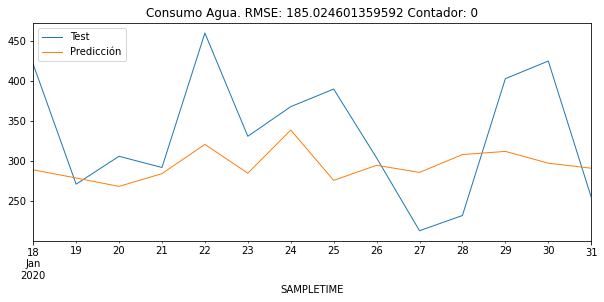

In [15]:
# Un modelo diario
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
Proyecto.GraficasEstadisticas()

In [16]:
#data_tuples = list(zip(Proyecto.RMSE_Todos,Proyecto.RMSE_Todos_IDs))
#resultados=pd.DataFrame(data_tuples,columns=['RMSE_Normal','ID'])
#resultados.to_csv(path+'RMSE_Normal')
#print(resultados)

# COHERENCIA DE LOS DATOS

In [17]:
Proyecto.contadores[0].Predicciones

[0,
 289.06100000000004,
 278.89799999999997,
 268.356,
 284.34999999999997,
 320.85400000000004,
 284.881,
 338.81699999999995,
 275.89,
 294.77500000000003,
 285.84000000000003,
 308.16700000000003,
 312.09999999999997,
 297.42199999999997,
 291.114,
 2065.217,
 2065.308]

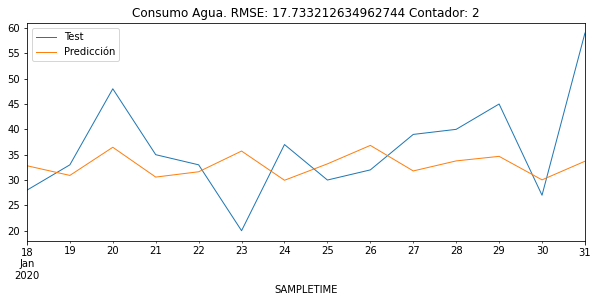

In [18]:
Proyecto.contadores[2].Predicciones
Proyecto.GraficasEstadisticas(contador=2,Test=True)

In [19]:
Proyecto.contadores[2711].Predicciones

[2711, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [20]:
Proyecto.RMSE_Test_Promedio

481.16956106616806

In [21]:
Proyecto.RMSE_Test_Suma

1306375.3582946463

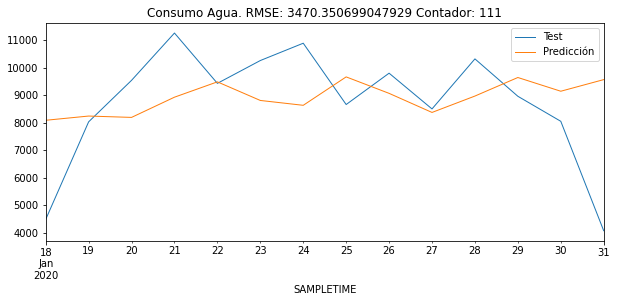

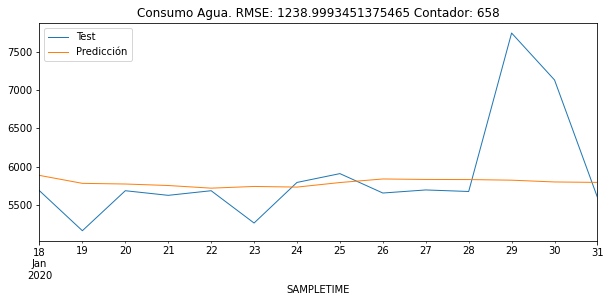

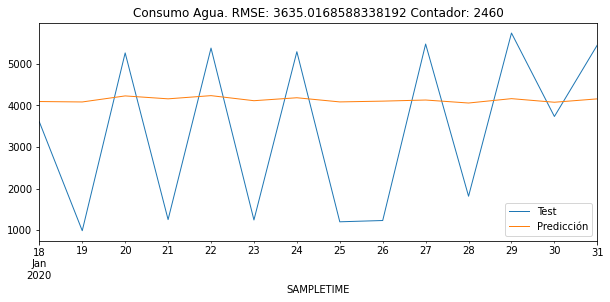

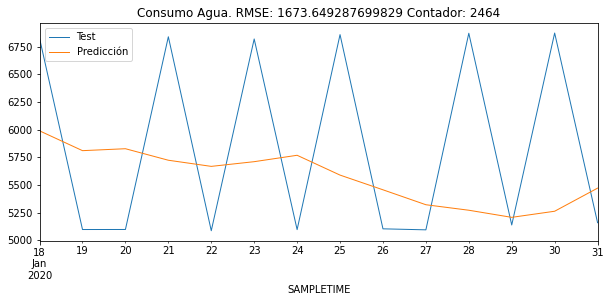

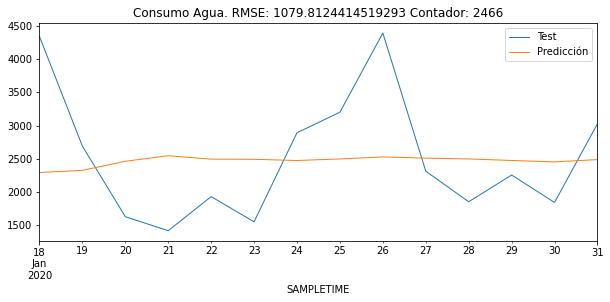

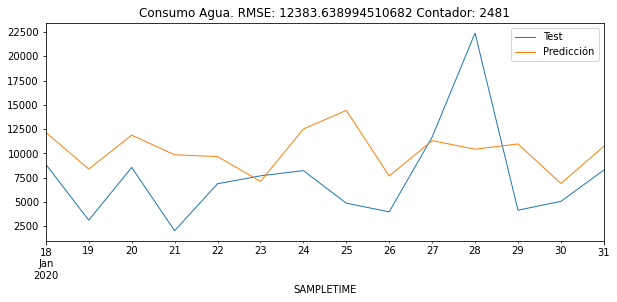

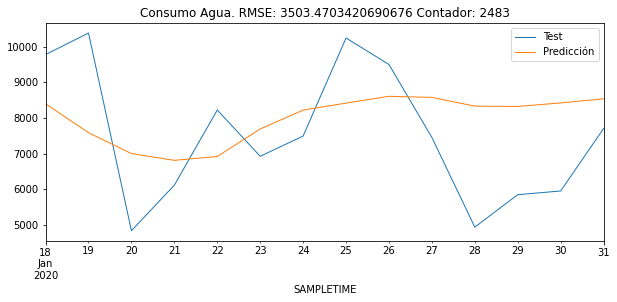

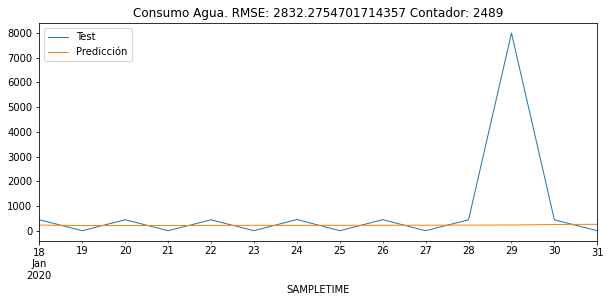

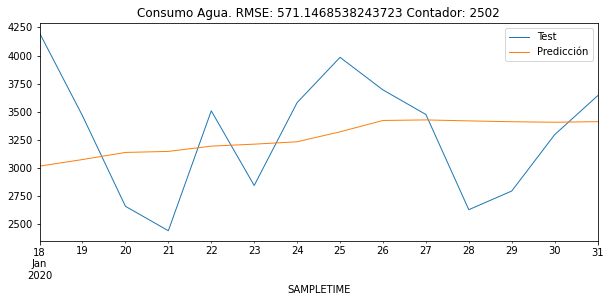

In [22]:
for ID in [111,658,2460,2464,2466,2481,2483,2489,2502]:
    Proyecto.GraficasEstadisticas(contador=ID)